In [ ]:
!ls -lh ../smal.fasta

In [397]:
%%bash
source ~/.bashrc
conda activate assembly
blastn -query ../smal.fasta -subject ../smal.fasta \
    -outfmt "6 qseqid staxids bitscore std" \
    -max_target_seqs 100 -max_hsps 100 \
    -num_threads 20 \
    -evalue 1e-25 \
    -out ../smal.out

In [398]:
%%bash
source ~/.bashrc
conda activate assembly
blastn -query ../sfon.fasta -subject ../sfon.fasta \
    -outfmt "6 qseqid staxids bitscore std" \
    -max_target_seqs 100 -max_hsps 100 \
    -num_threads 20 \
    -evalue 1e-25 \
    -out ../sfon.out

In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv("../smal.out", sep = "\t", header = None)

In [3]:
data = data[data[3] != data[4]].reset_index(drop=True)

/tmp/ipykernel_2302777/3822295808.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[5])


<Axes: xlabel='5', ylabel='Density'>

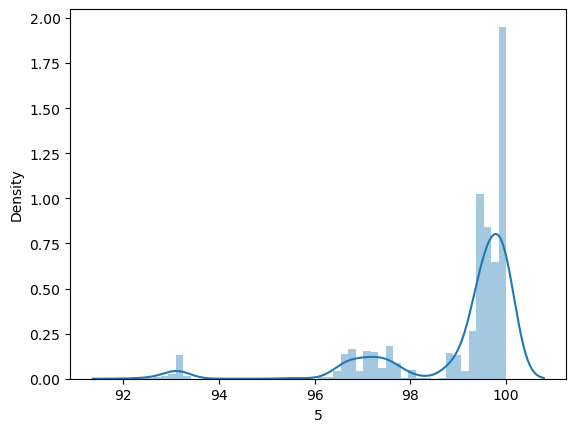

In [415]:
sns.distplot(data[5])

In [5]:
data[data[5] > 96][data[5] < 98].sort_values(5)

/tmp/ipykernel_61142/3173207954.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data[data[5] > 96][data[5] < 98].sort_values(5)


0   1     2            3           4       5     6   7   8   \
1539   OM362908.1 NaN  1639   OM362908.1  OR068300.1  96.127  1007  33   5   
6096   OR068300.1 NaN  1639   OR068300.1  OM362908.1  96.127  1007  33   5   
1537   OM362908.1 NaN  1729   OM362908.1  MZ389440.1  96.223  1059  34   5   
2091   MZ389440.1 NaN  1729   MZ389440.1  OM362908.1  96.223  1059  34   5   
6094   OR068300.1 NaN  1644   OR068300.1  OM362907.1  96.226  1007  33   4   
...           ...  ..   ...          ...         ...     ...   ...  ..  ..   
1326   OM362906.1 NaN  1993   OM362906.1  OP113713.1  97.753  1157  26   0   
1584  NC_068270.1 NaN  1993  NC_068270.1  OP113713.1  97.753  1157  26   0   
4490   OP113713.1 NaN  1993   OP113713.1  OM362905.1  97.753  1157  26   0   
2101   MZ389440.1 NaN   161   MZ389440.1  LC578933.1  97.849    93   2   0   
6225   LC578933.1 NaN   161   LC578933.1  MZ389440.1  97.849    93   2   0   

         9      10     11     12            13  
1539  15650  16652      1   1005  0.000000e+00  
6096      1   1005  15650  16652  0.000000e+00  
1537  15598  16652      1   1057  0.000000e+00  
2091      1   1057  15598  16652  0.000000e+00  
6094      1   1005  15650  16653  0.000000e+00  
...     ...    ...    ...    ...           ...  
1326  15496  16652      1   1157  0.000000e+00  
1584  15496  16652      1   1157  0.000000e+00  
4490      1   1157  15496  16652  0.000000e+00  
2101   1371   1463      1     93  8.260000e-41  
6225      1     93   1371   1463  8.770000e-42  

[1018 rows x 14 columns]

In [394]:
!cat ../blast_asvs.sh

#!/bin/bash
#SBATCH --partition=open
#SBATCH --nodes=1
#SBATCH --ntasks=20
#SBATCH --mem=256GB
#SBATCH --time=48:00:00
#SBATCH --job-name=blastn

source ~/.bashrc
conda activate assembly

cd /storage/group/ibb3/default/acro_popgen_variants/trout_mitoassembly/

blastn -query ./dada2_asvs.fasta \
    -db /scratch/nsl5160/db/core_nt \
    -outfmt "6 qseqid staxids bitscore std" \
    -max_target_seqs 100 -max_hsps 100 \
    -num_threads 20 \
    -evalue 1e-25 \
    -out ./dada2_asvs_core_nt.out


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import distance
from skbio.diversity import beta_diversity
from skbio.diversity import alpha_diversity
from scipy.cluster import hierarchy
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import colorcet as cc
from scipy.stats import pearsonr

In [2]:
metadata = pd.read_csv("../master_metadata.csv")
metadata.loc[metadata["Site"] == "Blank", "Name"] = "Field Blank"
metadata.loc[metadata["Site"] == "Extraction Blank", "Name"] = "Extraction Blank"
metadata.loc[metadata["Site"] == "PCR Blank", "Name"] = "PCR Blank"
metadata = metadata[metadata["EGCF-ID"].notna()].reset_index(drop=True)

In [3]:
asv = pd.read_csv("../dada2_asv_table_with_taxonomy.csv")
asv["Overall_Best"] = asv["Best_Hit_Refseq"]
asv["Overall_Best_Percent_ID"] = asv["Percent_ID_Refseq"]
asv["Overall_Best_Taxonomic_Level"] = asv['Best_Hit_Taxonomic_level_Refseq']
asv.loc[(asv["Percent_ID_Refseq"] < 98) & (asv["evalue_Refseq"] > asv["evalue"]), "Overall_Best"] = asv["Best_Hit"]
asv.loc[(asv["Percent_ID_Refseq"] < 98) & (asv["evalue_Refseq"] > asv["evalue"]), "Overall_Best_Percent_ID"] = asv["Percent_ID"]
asv.loc[(asv["Percent_ID_Refseq"] < 98) & (asv["evalue_Refseq"] > asv["evalue"]), "Overall_Best_Taxonomic_Level"] = asv['Best_Hit_Taxonomic_level']
asv = asv[asv["Class"] == "Actinopteri"].reset_index(drop=True)
fish = asv.copy()
#fish = asv[asv["CountsAcross"] > 10].reset_index(drop=True)
tmp = fish[fish.columns[2:-26].tolist() + ["Overall_Best"]].groupby('Overall_Best').transform('sum')
tmp[[i for i in fish.columns.tolist() if i not in tmp.columns.tolist()]] = fish[[i for i in fish.columns.tolist() if i not in tmp.columns.tolist()]]
tmp = tmp.drop_duplicates(fish.columns[2:-26].tolist() + ["Overall_Best"]).reset_index(drop=True)
fish = tmp.copy()
fish["Primer"] = "MiFish"
for samp in fish.columns[0:-29].tolist():
    fish.loc[fish[samp] < (fish[samp].sum() * 0.001), samp] = 0

In [4]:
tmp = fish[metadata["EGCF-ID"][metadata["Name"] == "East Lake"].tolist() + ["Overall_Best"]]

In [5]:
tmp["nonzero"] = tmp[metadata["EGCF-ID"][metadata["Name"] == "East Lake"].tolist()].astype(bool).sum(axis=1)

/fs/dss/scratch/7173879_noge4093_mpcs044/ipykernel_826302/788245563.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp["nonzero"] = tmp[metadata["EGCF-ID"][metadata["Name"] == "East Lake"].tolist()].astype(bool).sum(axis=1)


In [6]:
fish["in_nsamps"] = fish[fish.columns[0:-29].tolist()].astype(bool).sum(axis=1)
fish = fish[fish["in_nsamps"] > 1].reset_index(drop=True)

In [7]:
asv = pd.read_csv("../dada2_mussels_asv_table_with_taxonomy.csv")
asv = asv[asv["CountsAcross"] > 10].reset_index(drop=True)
mussels = asv[asv["Best_Hit"].notna()][asv["Best_Hit"] != "NA"].reset_index(drop=True)
mussels["Overall_Best"] = mussels["Best_Hit"]
tmp = mussels[mussels.columns[2:-24].tolist() + ["Best_Hit"]].groupby('Best_Hit').transform('sum')
tmp[[i for i in mussels.columns.tolist() if i not in tmp.columns.tolist()]] = mussels[[i for i in mussels.columns.tolist() if i not in tmp.columns.tolist()]]
tmp = tmp.drop_duplicates(mussels.columns[2:-24].tolist() + ["Best_Hit"]).reset_index(drop=True)
mussels = tmp.copy()
mussels["Overall_Best"] = mussels["Best_Hit"]
mussels["Primer"] = "Mussel"
for samp in mussels.columns[0:-27].tolist():
    mussels.loc[mussels[samp] < (mussels[samp].sum() * 0.001), samp] = 0

/fs/dss/scratch/7173879_noge4093_mpcs044/ipykernel_826302/2494241999.py:1: DtypeWarning: Columns (394,395,396,397,398,399,400,403,404,405,406,407,408,409,412,414) have mixed types. Specify dtype option on import or set low_memory=False.
  asv = pd.read_csv("../dada2_mussels_asv_table_with_taxonomy.csv")
/fs/dss/scratch/7173879_noge4093_mpcs044/ipykernel_826302/2494241999.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mussels = asv[asv["Best_Hit"].notna()][asv["Best_Hit"] != "NA"].reset_index(drop=True)


In [8]:
meta = pd.read_csv("../master_metadata.csv")

In [9]:
meta = meta[["Name", "Season", "Description", "EGCF-ID"]]
meta.columns = ["Name", "Season", "Habitat", "index"]

In [19]:
tmpass = mussels[mussels.columns[0:-27].tolist() + ["Overall_Best"]]

In [20]:
tmpass = tmpass.set_index("Overall_Best").T.reset_index(drop=False)

In [21]:
tmpass = tmpass.merge(meta[["index", "Habitat", "Name"]], how = "left", on = "index")

In [24]:
tmpass.columns

Index(['index', 'Elliptio', 'Elliptio complanata', 'Utterbackia imbecillis',
       'Elliptio hopetonensis', 'Habitat', 'Name'],
      dtype='object')

In [26]:
pd.DataFrame(tmpass[tmpass["Elliptio hopetonensis"]!=0].value_counts(["Name","Habitat"])).reset_index(drop=False).sort_values(["Name", "Habitat"])

Name     Habitat  count
0  Moss Lake  Near Shore      1

In [25]:
pd.DataFrame(tmpass[tmpass["Elliptio complanata"]!=0].value_counts(["Name","Habitat"])).reset_index(drop=False).sort_values(["Name", "Habitat"])

Name     Habitat  count
2  Sagamore        Deep      3
0  Sagamore  Near Shore     12
1  Sagamore     Surface      4

In [23]:
pd.DataFrame(tmpass[tmpass["Elliptio"]!=0].value_counts(["Name","Habitat"])).reset_index(drop=False).sort_values(["Name", "Habitat"])

Name     Habitat  count
8   East Lake   Nearshore      4
10  East Lake     Surface      2
12      Heart        Deep      1
11      Heart  Near Shore      1
9   Moss Lake        Deep      3
0   Moss Lake  Near Shore     10
1   Moss Lake     Surface     10
6     Rondaxe        Deep      6
5     Rondaxe  Near Shore      7
3     Rondaxe     Surface      8
7    Sagamore        Deep      5
4    Sagamore  Near Shore      7
2    Sagamore     Surface      8

In [228]:
musseloccur = pd.DataFrame()
tmp = pd.DataFrame(tmpass[tmpass["Elliptio"] != 0 ].value_counts(["Name", "Description"])).reset_index(drop=False)
tmp.columns = ["Lake", "Habitat", "Number of Sites Detected"]
tmp["Taxon"] = "Elliptio"
musseloccur = pd.concat([musseloccur, tmp]).reset_index(drop=True)
tmp = pd.DataFrame(tmpass[tmpass["Elliptio complanata"] != 0 ].value_counts(["Name", "Description"])).reset_index(drop=False)
tmp.columns = ["Lake", "Habitat", "Number of Sites Detected"]
tmp["Taxon"] = "Elliptio complanata"
musseloccur = pd.concat([musseloccur, tmp]).reset_index(drop=True)
tmp = pd.DataFrame(tmpass[tmpass["Elliptio hopetonensis"] != 0 ].value_counts(["Name", "Description"])).reset_index(drop=False)
tmp.columns = ["Lake", "Habitat", "Number of Sites Detected"]
tmp["Taxon"] = "Elliptio hopetonensis"
musseloccur = pd.concat([musseloccur, tmp]).reset_index(drop=True)
tmp = pd.DataFrame(tmpass[tmpass["Utterbackia imbecillis"] != 0 ].value_counts(["Name", "Description"])).reset_index(drop=False)
tmp.columns = ["Lake", "Habitat", "Number of Sites Detected"]
tmp["Taxon"] = "Utterbackia imbecillis"
musseloccur = pd.concat([musseloccur, tmp]).reset_index(drop=True)

In [232]:
tmpass[tmpass["Utterbackia imbecillis"] != 0]

index  Elliptio  Elliptio complanata  Utterbackia imbecillis  \
267    34     19340                    0                   14195   

     Elliptio hopetonensis   dendro_name       Name Description   Colors  
267                      0  Moss Lake_34  Moss Lake     Surface  #bae1ff

In [217]:
tmpass[tmpass["Elliptio complanata"] != 0 ].value_counts(["Name", "Description"])

Name      Description
Sagamore  Near Shore     12
          Surface         4
          Deep            3
Name: count, dtype: int64

In [218]:
tmpass[tmpass["Elliptio hopetonensis"] != 0 ].value_counts(["Name", "Description"])

Name       Description
Moss Lake  Near Shore     1
Name: count, dtype: int64

In [219]:
tmpass[tmpass["Utterbackia imbecillis"] != 0 ].value_counts(["Name", "Description"])

Name       Description
Moss Lake  Surface        1
Name: count, dtype: int64

In [91]:
mussels["in_nsamps"] = mussels[mussels.columns[0:-27].tolist()].astype(bool).sum(axis=1)
mussels = mussels[mussels["in_nsamps"] > 1].reset_index(drop=True)

In [92]:
asv = pd.read_csv("../dada2_insects_asv_table_with_taxonomy.csv")
asv = asv[asv["CountsAcross"] > 10].reset_index(drop=True)
insects = asv[asv["Best_Hit"].notna()][asv["Best_Hit"] != "NA"][asv["Best_Hit_Taxonomic_level"].isin(["Species", "Genus", "Family"])].reset_index(drop=True)
insects = insects[insects.columns[2:-21].tolist() + ["Family", 'Order', "Class", "Phylum"]]
tmp = insects.groupby('Family').transform('sum')
tmp[[i for i in insects.columns.tolist() if i not in tmp.columns.tolist()]] = insects[[i for i in insects.columns.tolist() if i not in tmp.columns.tolist()]]
tmp = tmp.drop_duplicates(insects.columns[2:-21].tolist() + ["Family"]).reset_index(drop=True)
insects = tmp.copy()
insects["Overall_Best"] = insects["Family"]
insects["Primer"] = "Insects"
for samp in insects.columns[0:-8].tolist():
    insects.loc[insects[samp] < (insects[samp].sum() * 0.001), samp] = 0

/fs/dss/scratch/7144300_noge4093_mpcs052/ipykernel_3467368/1398026162.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  insects = asv[asv["Best_Hit"].notna()][asv["Best_Hit"] != "NA"][asv["Best_Hit_Taxonomic_level"].isin(["Species", "Genus", "Family"])].reset_index(drop=True)
/fs/dss/scratch/7144300_noge4093_mpcs052/ipykernel_3467368/1398026162.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  insects = asv[asv["Best_Hit"].notna()][asv["Best_Hit"] != "NA"][asv["Best_Hit_Taxonomic_level"].isin(["Species", "Genus", "Family"])].reset_index(drop=True)


In [93]:
insects["in_nsamps"] = insects[insects.columns[0:-8].tolist()].astype(bool).sum(axis=1)
insects = insects[insects["in_nsamps"] > 1].reset_index(drop=True)

In [94]:
mosslake = insects.columns[0:-6].tolist()

In [95]:
joined = pd.concat([fish, mussels, insects]).reset_index(drop=True)
joined = joined[joined["Overall_Best"].notna()].reset_index(drop=True)

In [13]:
rename = metadata[["EGCF-ID", "Name", "Description"]]
rename.columns = ["index", "Name", "Description"]
rename = rename.fillna("NA")

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

In [206]:
df = joined[joined["Primer"].isin(["MiFish"])].reset_index(drop=True)
df = df[df.columns[0:-31].tolist() + ["Overall_Best"]].reset_index(drop=True)

df = joined[mosslake + ["Overall_Best"]]

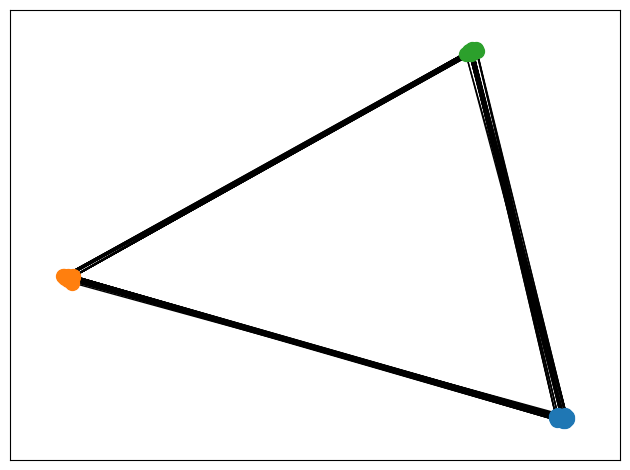

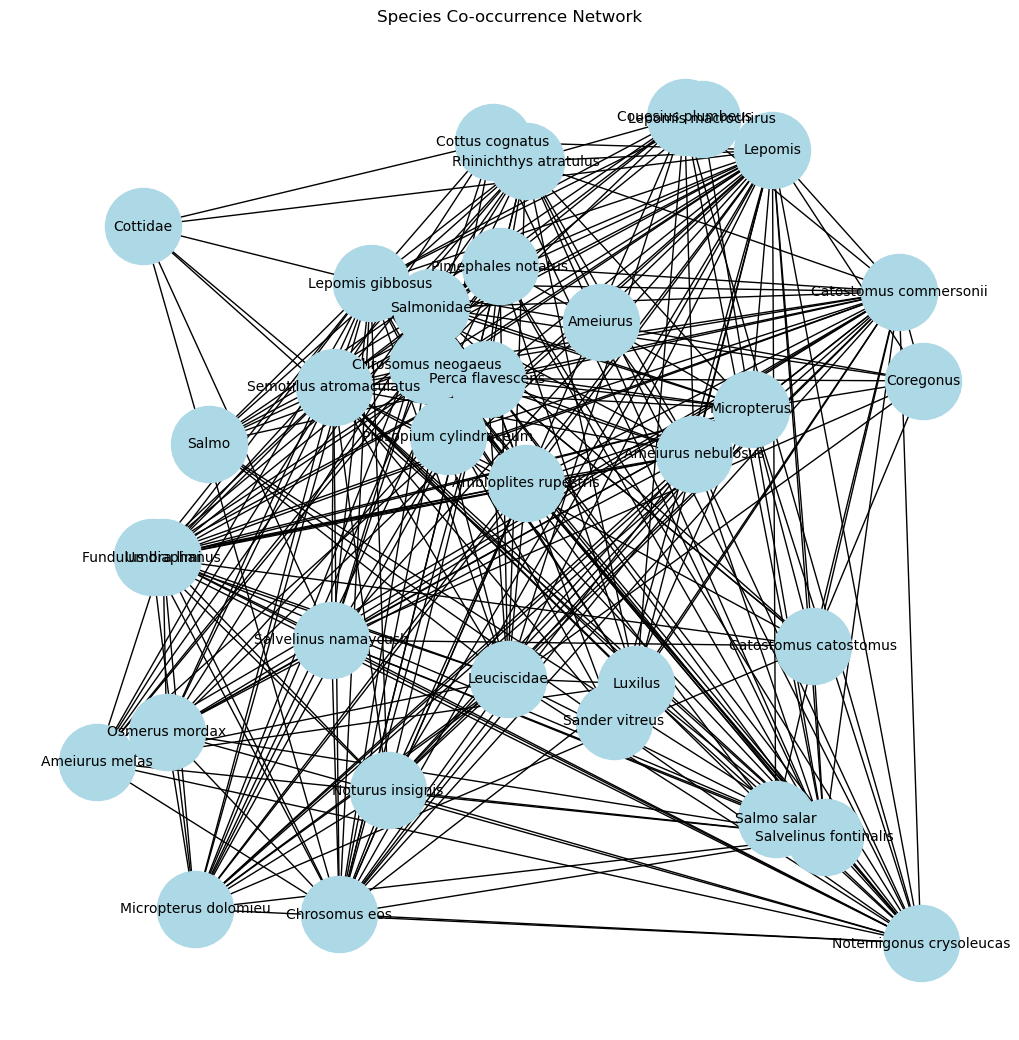

Least connected nodes:
Node: Ameiurus, Degree: 1
Node: Lepomis macrochirus, Degree: 4
Node: Prosopium cylindraceum, Degree: 4
Node: Salmo salar, Degree: 6
Node: Sander vitreus, Degree: 6

Most connected nodes:
Node: Salvelinus fontinalis, Degree: 28
Node: Semotilus atromaculatus, Degree: 29
Node: Catostomus commersonii, Degree: 30
Node: Lepomis, Degree: 33
Node: Lepomis gibbosus, Degree: 33
Pairs of nodes that never connect:
('Ambloplites rupestris', 'Ameiurus')
('Ambloplites rupestris', 'Ameiurus melas')
('Ambloplites rupestris', 'Catostomus catostomus')
('Ambloplites rupestris', 'Chrosomus neogaeus')
('Ambloplites rupestris', 'Coregonus')
('Ambloplites rupestris', 'Cottidae')
('Ambloplites rupestris', 'Cottus cognatus')
('Ambloplites rupestris', 'Couesius plumbeus')
('Ambloplites rupestris', 'Lepomis macrochirus')
('Ambloplites rupestris', 'Luxilus')
('Ambloplites rupestris', 'Osmerus mordax')
('Ambloplites rupestris', 'Pimephales notatus')
('Ambloplites rupestris', 'Prosopium cylind

In [187]:
networkdata = df.groupby(['Overall_Best']).sum().reset_index(drop=False)
networkdata = networkdata[["Overall_Best"] + 
            [i for i in networkdata.columns.tolist() if i in 
             metadata["EGCF-ID"].tolist()]]
networkdata = networkdata.set_index("Overall_Best").T
co_occurrence = networkdata.T.dot(networkdata)
co_occurrence = co_occurrence.where(co_occurrence != 0, 0)
G = nx.from_pandas_adjacency(co_occurrence)
G.remove_nodes_from(list(nx.isolates(G)))
G.remove_edges_from(list(nx.selfloop_edges(G)))
communities = nx.community.greedy_modularity_communities(G)
# Compute positions for the node clusters as if they were themselves nodes in a
# supergraph using a larger scale factor
supergraph = nx.cycle_graph(len(communities))
superpos = nx.spring_layout(G, scale=50, seed=429)

# Use the "supernode" positions as the center of each node cluster
centers = list(superpos.values())
pos = {}
for center, comm in zip(centers, communities):
    pos.update(nx.random_layout(nx.subgraph(G, comm), center=center))

# Nodes colored by cluster
for nodes, clr in zip(communities, ("tab:blue", "tab:orange", "tab:green")):
    nx.draw_networkx_nodes(G, pos=pos, nodelist=nodes, node_color=clr, node_size=100)
nx.draw_networkx_edges(G, pos=pos)

plt.tight_layout()
plt.show()

# Create a graph


# Draw the graph
plt.figure(figsize=(10, 10))
pos = nx.random_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', 
        node_size=3000, font_size=10, font_color='black')
plt.title('Species Co-occurrence Network')
plt.show()

degree_dict = dict(G.degree())

import itertools

sorted_nodes = sorted(degree_dict.items(), key=lambda x: x[1])

# Get least connected nodes
least_connected_nodes = sorted_nodes[:5]  # Change 5 to the number you want
most_connected_nodes = sorted_nodes[-5:]  # Change 5 to the number you want

# Print least connected nodes
print("Least connected nodes:")
for node, degree in least_connected_nodes:
    print(f'Node: {node}, Degree: {degree}')

# Print most connected nodes
print("\nMost connected nodes:")
for node, degree in most_connected_nodes:
    print(f'Node: {node}, Degree: {degree}')
    
node_pairs = itertools.combinations(G.nodes, 2)

# Find pairs that never connect
never_connecting_pairs = [(node1, node2) for node1, node2 in node_pairs if not G.has_edge(node1, node2)]

# Print results
print("Pairs of nodes that never connect:")
for pair in never_connecting_pairs:
    print(pair)

In [96]:
hex_unique_colors = [
    '#a1c9f4',  # Light Blue
    '#ffb482',  # Light Peach
    '#8de5a1',  # Light Green
    '#ff9f9b',  # Light Pink
    '#d0bbff',  # Light Purple
    '#fffea3',  # Light Yellow
    '#b9f2f0',  # Light Aqua
    '#fab0e4',  # Light Magenta
    '#cfcfcf',  # Light Gray
    '#ffcccb',  # Light Coral
    '#bae1ff',  # Light Sky Blue
    '#ffd1dc',  # Light Rose
    '#b5ead7',  # Light Mint
    '#ffdfba',  # Light Apricot
    '#ffdac1',  # Light Melon
    '#e2f0cb'   # Light Lime
]


In [97]:
rename["Colors"] = np.nan
index = 0
for i in rename.Name.unique():
    rename.loc[rename["Name"] == i, "Colors"] = hex_unique_colors[index]
    index = index + 1

/fs/dss/scratch/7144300_noge4093_mpcs052/ipykernel_3467368/1721115863.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '#a1c9f4' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  rename.loc[rename["Name"] == i, "Colors"] = hex_unique_colors[index]


In [98]:
rename["dendro_name"] = rename["Name"] + "_" + rename["index"].astype(str)

In [99]:
colors = rename[["dendro_name", "Colors"]]

In [100]:
colordict = {}
for i in range(len(colors)):
    colordict[colors["dendro_name"][i]] = colors["Colors"][i]

In [101]:
dflt_col = "#808080"   # Unclustered gray

In [82]:
asvs = joined[joined["Primer"] == "MiFish"].set_index("Overall_Best").T.reset_index(drop=False)
bc_data = asvs.merge(rename, on = "index", how = "left")

In [25]:
rename["dendro_name"] = rename["Name"] + "_" + rename["index"].astype(str)

In [112]:
asvs = joined[joined["Primer"] == "MiFish"].set_index("Overall_Best").T.reset_index(drop=False)
bc_data = asvs.merge(rename[["Name", "index"]], on = "index", how = "left")
#bc_data = bc_data[~bc_data["index"].isin(["PB1", "PB2"])]
bc_data = bc_data[bc_data["Name"].notna()]
bc_data["Name"] = bc_data["Name"] + "_" + bc_data["index"]

/fs/dss/scratch/7144300_noge4093_mpcs052/ipykernel_3467368/2660086448.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  bc_data = bc_data.fillna(0)
/fs/dss/scratch/7144300_noge4093_mpcs052/ipykernel_3467368/2660086448.py:22: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = hierarchy.linkage(bc_dm_data, "weighted", optimal_ordering = True)


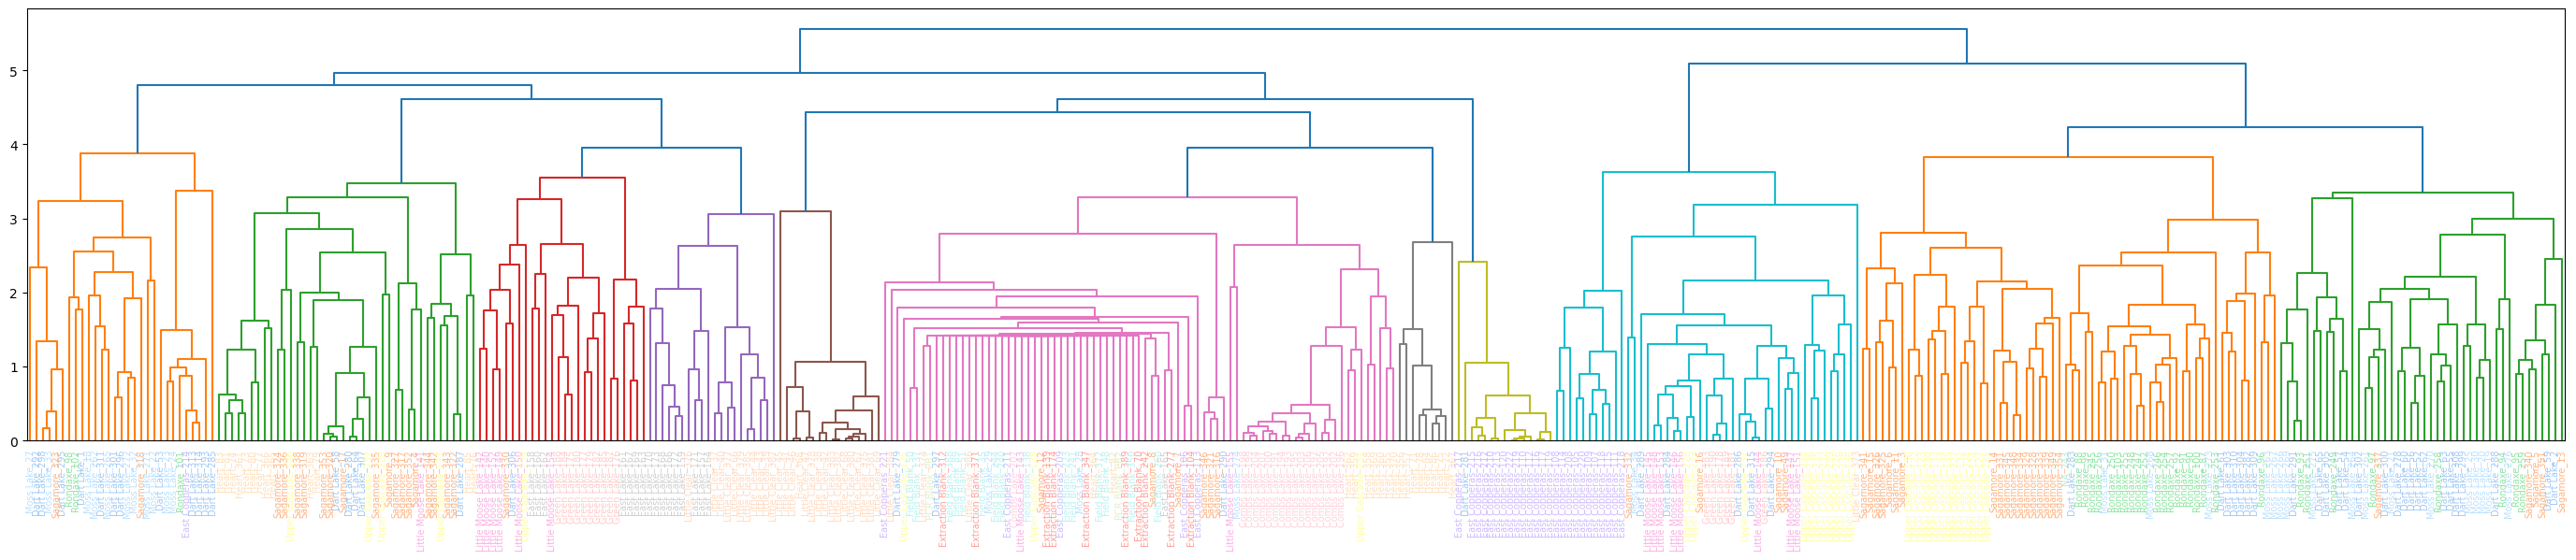

In [128]:
asvs = joined[joined["Primer"] == "MiFish"].set_index("Overall_Best").T.reset_index(drop=False)
bc_data = asvs.merge(rename[["Name", "index"]], on = "index", how = "left")
#bc_data = bc_data[~bc_data["index"].isin(["PB1", "PB2"])]
bc_data = bc_data[bc_data["Name"].notna()]
bc_data["Name"] = bc_data["Name"] + "_" + bc_data["index"]
bc_data = bc_data[bc_data.columns[1:]].set_index("Name").T
bc_data = bc_data.fillna(0)
ids = bc_data.columns.tolist()
data = []
for samp in ids:
    #bc_data[samp] = bc_data[samp] / bc_data[samp].sum() ##Scale to 0 to 1 per samples
    #bc_data.loc[bc_data[samp] > 0, samp] = 1 ##Scale into binary for each sample
    tmp = bc_data[samp].tolist()
    data = data + [tmp]
bc_dm = beta_diversity("braycurtis", data, ids)
bc_dm_data = pd.DataFrame(bc_dm.data)
imputer = SimpleImputer(strategy = "most_frequent")
out = imputer.fit_transform(bc_dm_data)
bc_dm_data = pd.DataFrame(out, index=bc_dm_data.index, columns=bc_dm_data.columns)
bc_dm_data = bc_dm_data.to_numpy()
plt.figure(figsize=(35, 6))
Z = hierarchy.linkage(bc_dm_data, "weighted", optimal_ordering = True)


hierarchy.dendrogram(
    Z,
    #leaf_rotation=0.,  # rotates the x axis labels
    leaf_font_size=7.,  # font size for the x axis labels
    labels=bc_dm.ids,
    orientation="top"
)
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
num=-1
for lbl in xlbls:
    num+=1
    lbl.set_color(colordict[lbl.get_text()])
plt.savefig("../dendrogram_untransformed_insects.pdf", dpi = 300, bbox_inches='tight')

/fs/dss/scratch/7144300_noge4093_mpcs052/ipykernel_3467368/363296518.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  bc_data = bc_data.fillna(0)


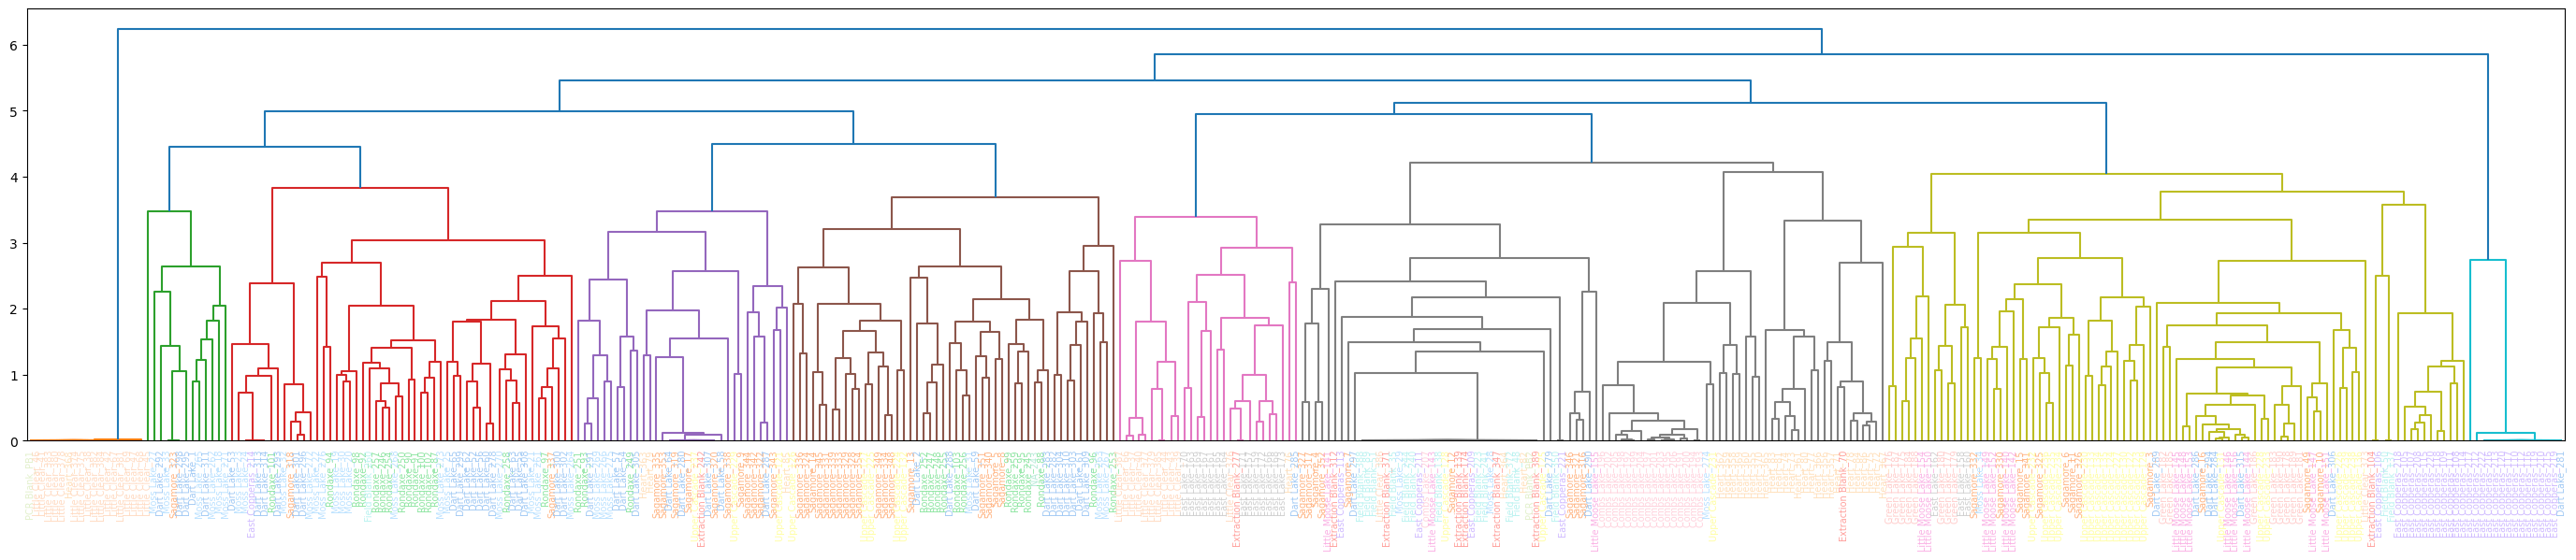

In [127]:
asvs = joined[joined["Primer"] == "MiFish"].set_index("Overall_Best").T.reset_index(drop=False)
bc_data = asvs.merge(rename[["Name", "index"]], on = "index", how = "left")
#bc_data = bc_data[~bc_data["index"].isin(["PB1", "PB2"])]
bc_data = bc_data[bc_data["Name"].notna()]
bc_data["Name"] = bc_data["Name"] + "_" + bc_data["index"]
bc_data = bc_data[bc_data.columns[1:]].set_index("Name").T
bc_data = bc_data.fillna(0)
ids = bc_data.columns.tolist()
data = []
for samp in ids:
    bc_data[samp] = bc_data[samp] / bc_data[samp].sum() ##Scale to 0 to 1 per samples
    #bc_data.loc[bc_data[samp] > 0, samp] = 1 ##Scale into binary for each sample
    tmp = bc_data[samp].tolist()
    data = data + [tmp]
bc_dm = beta_diversity("braycurtis", data, ids)
bc_dm_data = pd.DataFrame(bc_dm.data)
imputer = SimpleImputer(strategy = "most_frequent")
out = imputer.fit_transform(bc_dm_data)
bc_dm_data = pd.DataFrame(out, index=bc_dm_data.index, columns=bc_dm_data.columns)
bc_dm_data = bc_dm_data.to_numpy()
plt.figure(figsize=(35, 6))
Z = hierarchy.linkage(bc_dm_data, "weighted", optimal_ordering = True)
hierarchy.dendrogram(
    Z,
    #leaf_rotation=0.,  # rotates the x axis labels
    leaf_font_size=7.,  # font size for the x axis labels
    labels=bc_dm.ids,
    orientation="top"
)
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
num=-1
for lbl in xlbls:
    num+=1
    lbl.set_color(colordict[lbl.get_text()])
plt.savefig("../dendrogram_minmax_scaled.pdf", dpi = 300, bbox_inches='tight')

In [ ]:
for i in metadata.Name.unique():
    try:
        tmp = mussels[metadata["EGCF-ID"][metadata["Name"] == i].tolist() + ["Overall_Best"]]
        tmp['sum'] = tmp.sum(axis=1)
        print(tmp["Overall_Best"][tmp["sum"] > 0].tolist())
    except:
        pass

In [198]:
tmp["Overall_Best"][tmp["sum"] > 0].tolist()

['Elliptio', 'Utterbackia imbecillis', 'Elliptio hopetonensis']

In [37]:
samps = fish.columns[:-26].tolist()

In [50]:
asv = fish[fish["Overall_Best"] != "NA"][fish["Overall_Best"].notna()].reset_index(drop=True)

In [51]:
asv = pd.concat([asv.groupby(['Overall_Best'])[samps].transform('sum'), asv[["Overall_Best"]]], axis = 1).drop_duplicates()

In [52]:
asvs = asv.set_index("Overall_Best").T.reset_index(drop=False)

In [53]:
asvs = asvs.loc[:, (asvs != 0).any(axis=0)]

In [153]:
asvs = asvs.set_index("index").T

In [159]:
asv = asvs.set_index("index").T
for i in asv.columns:
    asv[i] = asv[i] / asv[i].sum()
asv = asv.T.reset_index(drop=False)

In [137]:
for lake in metadata["Name"].unique():
    tmp = asvs[asvs["index"].isin(metadata["EGCF-ID"][metadata["Name"] == lake].tolist())]
    tmp = tmp.loc[:, (tmp != 0).any(axis=0)]
    spp = tmp.columns[1:].tolist()
    if set(["Chrosomus eos", "Ambloplites rupestris"]).issubset(set(spp)):
        print(lake)
        print(spp)

Dart Lake
['Lepomis', 'Lepomis gibbosus', 'Perca flavescens', 'Micropterus', 'Salvelinus fontinalis', 'Catostomus commersonii', 'Semotilus atromaculatus', 'Umbra limi', 'Ameiurus nebulosus', 'Micropterus dolomieu', 'Micropterus salmoides', 'Salvelinus namaycush', 'Ambloplites rupestris', 'Chrosomus eos', 'Ameiurus', 'Fundulus diaphanus', 'Salvelinus malma', 'Umbra', 'Noturus insignis', 'Ambloplites', 'Ambloplites ariommus', 'Catostomus']
Rondaxe
['Lepomis', 'Lepomis gibbosus', 'Perca flavescens', 'Micropterus', 'Salvelinus fontinalis', 'Catostomus commersonii', 'Semotilus atromaculatus', 'Umbra limi', 'Notemigonus crysoleucas', 'Ameiurus nebulosus', 'Micropterus dolomieu', 'Micropterus salmoides', 'Chrosomus neogaeus', 'Ambloplites rupestris', 'Chrosomus eos', 'Pimephales notatus', 'Ameiurus', 'Fundulus diaphanus', 'Umbra', 'Noturus insignis', 'Leuciscidae', 'Ambloplites', 'Ambloplites ariommus']


In [132]:
for lake in metadata["Name"].unique():
    tmp = asvs[asvs["index"].isin(metadata["EGCF-ID"][metadata["Name"] == lake].tolist())]
    tmp = tmp.loc[:, (tmp != 0).any(axis=0)]
    spp = tmp.columns[1:].tolist()
    if set(["Micropterus dolomieu", "Micropterus salmoides"]).issubset(set(spp)):
        print(lake)
        print(spp)

Dart Lake
['Lepomis', 'Lepomis gibbosus', 'Perca flavescens', 'Micropterus', 'Salvelinus fontinalis', 'Catostomus commersonii', 'Semotilus atromaculatus', 'Umbra limi', 'Ameiurus nebulosus', 'Micropterus dolomieu', 'Micropterus salmoides', 'Salvelinus namaycush', 'Ambloplites rupestris', 'Chrosomus eos', 'Ameiurus', 'Fundulus diaphanus', 'Salvelinus malma', 'Umbra', 'Noturus insignis', 'Ambloplites', 'Ambloplites ariommus', 'Catostomus']
Sagamore
['Lepomis', 'Lepomis gibbosus', 'Perca flavescens', 'Micropterus', 'Salvelinus fontinalis', 'Catostomus commersonii', 'Semotilus atromaculatus', 'Notemigonus crysoleucas', 'Ameiurus nebulosus', 'Micropterus dolomieu', 'Micropterus salmoides', 'Chrosomus neogaeus', 'Salvelinus namaycush', 'Ameiurus', 'Lepomis macrochirus', 'Salvelinus malma', 'Coregonus', 'Catostomus catostomus', 'Salmo salar', 'Salmonidae', 'Coregonus clupeaformis']
Rondaxe
['Lepomis', 'Lepomis gibbosus', 'Perca flavescens', 'Micropterus', 'Salvelinus fontinalis', 'Catostomus 

/tmp/ipykernel_2302777/3159254949.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.scatterplot(data = asv[["Chrosomus eos", "Ambloplites rupestris"]][(asv["Chrosomus eos"] > 0) | (asv["Ambloplites rupestris"] > 0)][asv["index"].isin(metadata["EGCF-ID"][metadata["Name"].isin(["Dart Lake", "Sagamore", "Rondaxe"])])],


<Axes: xlabel='Chrosomus eos', ylabel='Ambloplites rupestris'>

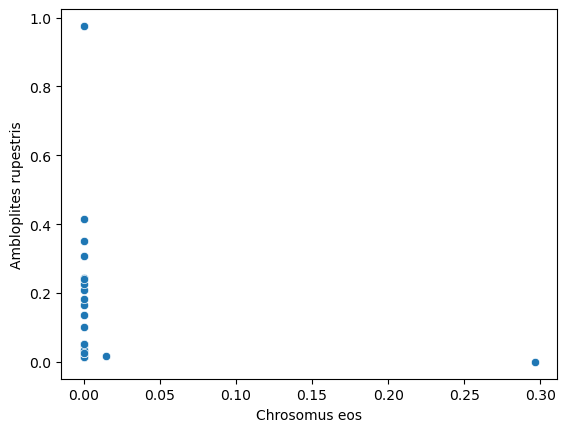

In [162]:
sns.scatterplot(data = asv[["Chrosomus eos", "Ambloplites rupestris"]][(asv["Chrosomus eos"] > 0) | (asv["Ambloplites rupestris"] > 0)][asv["index"].isin(metadata["EGCF-ID"][metadata["Name"].isin(["Dart Lake", "Sagamore", "Rondaxe"])])], 
                x = "Chrosomus eos", y = "Ambloplites rupestris")

/tmp/ipykernel_2302777/2717382345.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.scatterplot(data = asvs[["Micropterus dolomieu", "Micropterus salmoides"]][(asvs["Micropterus dolomieu"] > 0) | (asvs["Micropterus salmoides"] > 0)][asvs["index"].isin(metadata["EGCF-ID"][metadata["Name"].isin(["Rondaxe", "Sagamore", "Dart Lake"])])],


<Axes: xlabel='Micropterus dolomieu', ylabel='Micropterus salmoides'>

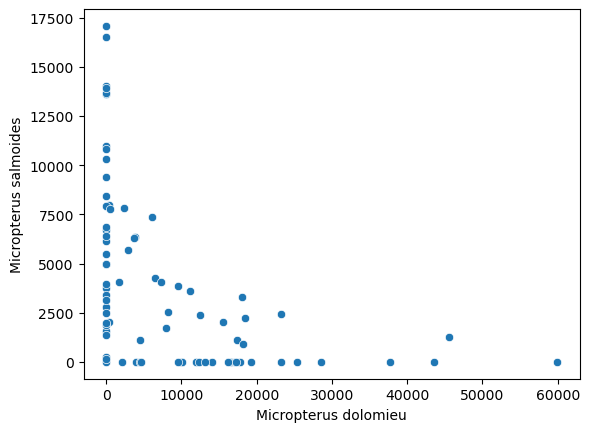

In [133]:
sns.scatterplot(data = asvs[["Micropterus dolomieu", "Micropterus salmoides"]][(asvs["Micropterus dolomieu"] > 0) | (asvs["Micropterus salmoides"] > 0)][asvs["index"].isin(metadata["EGCF-ID"][metadata["Name"].isin(["Rondaxe", "Sagamore", "Dart Lake"])])], 
                x = "Micropterus dolomieu", y = "Micropterus salmoides")

/tmp/ipykernel_2302777/2345547627.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.scatterplot(data = asvs[["Micropterus dolomieu", "Semotilus atromaculatus"]][(asvs["Micropterus dolomieu"] > 0) | (asvs["Semotilus atromaculatus"] > 0)][asvs["index"].isin(metadata["EGCF-ID"][metadata["Name"].isin(["Rondaxe", "Little Moose Lake", "Sagamore", "Dart Lake"])])],


<Axes: xlabel='Micropterus dolomieu', ylabel='Semotilus atromaculatus'>

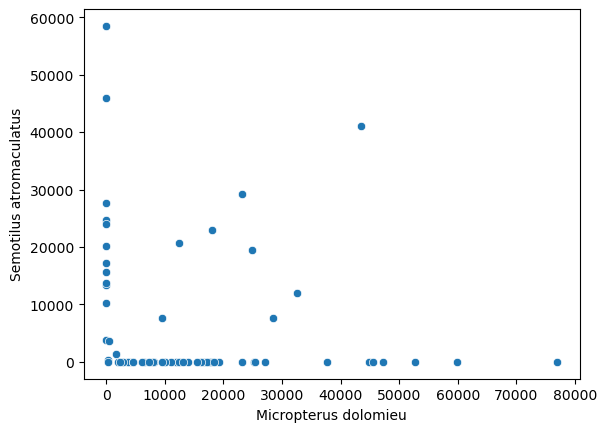

In [124]:
sns.scatterplot(data = asvs[["Micropterus dolomieu", "Semotilus atromaculatus"]][(asvs["Micropterus dolomieu"] > 0) | (asvs["Semotilus atromaculatus"] > 0)][asvs["index"].isin(metadata["EGCF-ID"][metadata["Name"].isin(["Rondaxe", "Little Moose Lake", "Sagamore", "Dart Lake"])])], 
                x = "Micropterus dolomieu", y = "Semotilus atromaculatus")

In [145]:
import scipy as sp

/tmp/ipykernel_2302777/4157679745.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sub = asv[["Micropterus dolomieu", "Micropterus salmoides"]][(asv["Micropterus dolomieu"] > 0) | (asv["Micropterus salmoides"] > 0)][asv["index"].isin(metadata["EGCF-ID"][metadata["Name"].isin(["Rondaxe", "Little Moose Lake", "Dart Lake"])])]


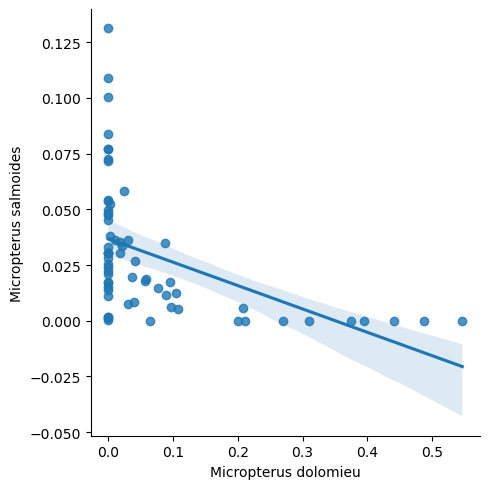

In [167]:
sub = asv[["Micropterus dolomieu", "Micropterus salmoides"]][(asv["Micropterus dolomieu"] > 0) | (asv["Micropterus salmoides"] > 0)][asv["index"].isin(metadata["EGCF-ID"][metadata["Name"].isin(["Rondaxe", "Little Moose Lake", "Dart Lake"])])]
sns.lmplot(data = sub, 
                x = "Micropterus dolomieu", y = "Micropterus salmoides")
r, p = sp.stats.pearsonr(sub["Micropterus dolomieu"], sub["Micropterus salmoides"])

In [168]:
r**2

0.22003847755483857

In [66]:
pd.DataFrame(metadata[metadata["EGCF-ID"].isin(asvs["index"][asvs["Rhinichthys atratulus"] > 0].tolist())].value_counts(["Name", "Description"])).sort_values("Name")

0
Name          Description   
East Lake     Nearshore    3
              Surface      3
              Deep         1
Heart         Near Shore   4
              Surface      3
              Deep         1
Moss Lake     Deep         1
              Near Shore   1
Upper Cascade Near Shore   7
              Surface      6
              Deep         2

In [62]:
pd.DataFrame(metadata[metadata["EGCF-ID"].isin(asvs["index"][asvs["Chrosomus eos"] > 0].tolist())].value_counts(["Name", "Description"])).sort_values("Name")

0
Name              Description   
Combs Lake        Surface      6
                  Deep         5
                  Nearshore    5
Dart Lake         Deep         1
East Lake         Deep         3
                  Blank        1
                  Surface      1
Green Lake        Surface      5
                  Nearshore    2
                  Deep         1
Heart             Near Shore   7
                  Surface      5
                  Deep         2
Little Moose Lake Deep         3
Rondaxe           Deep         1
Upper Cascade     Surface      1

In [63]:
pd.DataFrame(metadata[metadata["EGCF-ID"].isin(asvs["index"][asvs["Chrosomus neogaeus"] > 0].tolist())].value_counts(["Name", "Description"]).sort_values()).sort_values("Name")

0
Name          Description   
East Copperas Near Shore   1
Field Blank   Blank        1
Heart         Deep         3
              Surface      8
              Near Shore   9
Rondaxe       Deep         1
Sagamore      Surface      1
Upper Cascade Deep         3
              Near Shore   3
              Surface      7

In [64]:
pd.DataFrame(metadata[metadata["EGCF-ID"].isin(asvs["index"][asvs["Micropterus dolomieu"] > 0].tolist())].value_counts(["Name", "Description"]).sort_values()).sort_values("Name")

0
Name              Description    
Dart Lake         Deep          1
                  Surface       2
                  Near Shore    3
Little Moose Lake Surface       3
                  Nearshore     5
Rondaxe           Deep          4
                  Surface       6
                  Near Shore    8
Sagamore          Deep          1
                  Surface       9
                  Near Shore   13

In [350]:
metadata[metadata["EGCF-ID"].isin(asvs["index"][asvs["Elliptio complanata"] > 0].tolist())].value_counts(["Name", "Description"])

Name      Description
Sagamore  Near Shore     12
          Surface         4
          Deep            3
dtype: int64

In [348]:
metadata[metadata["EGCF-ID"].isin(asvs["index"][asvs["Elliptio"] > 0].tolist())].value_counts(["Name", "Description"])

Name       Description
Moss Lake  Near Shore     10
           Surface        10
Rondaxe    Surface         8
Sagamore   Surface         8
Rondaxe    Near Shore      7
Sagamore   Near Shore      7
Rondaxe    Deep            6
Sagamore   Deep            5
East Lake  Nearshore       4
Moss Lake  Deep            3
East Lake  Surface         2
Heart      Deep            1
           Near Shore      1
dtype: int64

In [347]:
metadata[metadata["EGCF-ID"].isin(asvs["index"][asvs["Elliptio"] > 0].tolist())]

Name       Date      Season  ALSC   Time Site Description EGCF-ID  \
5     Sagamore  6/20/2023      Spring     0   9:15   4A  Near Shore       6   
7     Sagamore  6/20/2023      Spring     0   9:25    4     Surface       8   
12    Sagamore  6/20/2023      Spring     0  11:50    2        Deep      13   
17   Moss Lake  5/24/2023      Spring     0  11:15   2A  Near Shore      18   
18   Moss Lake  5/24/2023      Spring     0  12:33   1A  Near Shore      19   
..         ...        ...         ...   ...    ...  ...         ...     ...   
339   Sagamore  9/29/2023  Early Fall     0  13:18   8A  Near Shore     342   
346   Sagamore  10/3/2023  Early Fall     0  10:38    1     Surface     349   
348   Sagamore  10/3/2023  Early Fall     0  11:25   9A  Near Shore     351   
360      Heart   9/5/2023  Early Fall     0  14:30   3A  Near Shore     363   
365      Heart   9/5/2023  Early Fall     0  10:30    5        Deep     368   

    Replicate  Latitude  Longitude  Water Depth eDNA  Vol. Filtered (ml)  \
5           1  43.77034  -74.61494          1.5    x               150.0   
7           1  43.76923  -74.61441         16.8    x               150.0   
12          1  43.76605   -74.6233          4.3    x               150.0   
17          1  43.78576  -74.84435          1.4    x               150.0   
18          1  43.78801   -74.8462          2.4    x               150.0   
..        ...       ...        ...          ...  ...                 ...   
339         1  43.76522  -74.62655          1.0    x               150.0   
346         1  43.76848   -74.6255         13.1    x               150.0   
348         1  43.77089   -74.6252          1.0    x               150.0   
360         1  44.18396  -73.96751          0.6    x               150.0   
365         1  44.18128  -73.96827          4.2    x               150.0   

     eDNA Depth (m)  Temp at Depth  DO at Depth  Secchi Depth (M)  \
5               0.0           18.6          8.9              3.75   
7               0.0           18.6          8.9              3.75   
12              3.0           14.9          8.6              3.75   
17              0.0           14.9          9.0              3.25   
18              0.0           14.9          9.0              3.25   
..              ...            ...          ...               ...   
339             0.0           16.0          8.6              1.70   
346             0.0           16.0          8.6              1.70   
348             0.0           16.0          8.6              1.70   
360             0.0           21.9          8.9               NaN   
365             3.0           20.7          8.1               NaN   

              Notes  
5               NaN  
7               NaN  
12              NaN  
17              NaN  
18              NaN  
..              ...  
339             NaN  
346             NaN  
348             NaN  
360  Missing Secchi  
365  Missing Secchi  

[72 rows x 19 columns]

In [327]:
metadata[metadata["EGCF-ID"].isin(asvs["index"][asvs["Elliptio"] > 0].tolist())].value_counts("Description")

Description
Surface       24
Near Shore    23
Deep          12
Nearshore      4
dtype: int64

In [319]:
metadata[metadata["EGCF-ID"] == "34"]

Name       Date  Season  ALSC Time    Site Description EGCF-ID  \
32  Moss Lake  5/25/2023  Spring     0  NaN  Outlet     Surface      34   

   Replicate  Latitude  Longitude  Water Depth eDNA  Vol. Filtered (ml)  \
32         1  43.78139  -74.85299          NaN    x               150.0   

    eDNA Depth (m)  Temp at Depth  DO at Depth  Secchi Depth (M) Notes  
32             0.0           14.9          9.0              3.25   NaN

In [286]:
rename = metadata[["EGCF-ID", "Name", "Description"]]
rename.columns = ["index", "Name", "Description"]
rename = rename.fillna("NA")

In [161]:
asvs = joined[rename["index"][rename["Name"].isin(["Moss Lake", "Extraction Blank"])].tolist() + ["Overall_Best"]][joined["Primer"] == "Insects"].set_index("Overall_Best").T.reset_index(drop=False)

In [178]:
tmp = pd.DataFrame(asvs.sum()).reset_index(drop=False)

In [179]:
tmp = tmp[tmp["Overall_Best"] != "index"]

In [181]:
tmp["perc"] = tmp[0] / tmp[0].sum()

In [187]:
tmp = tmp.head(10)
tmp.columns = ["Family", "Number of Reads", "Percent of Reads"]

In [188]:
tmp

Family Number of Reads Percent of Reads
1       Chironomidae       1226808.0         0.721117
2        Lauxaniidae        165379.0          0.09721
3        Chaoboridae         96201.0         0.056547
4      Caeciliusidae         25850.0         0.015195
5   Sericostomatidae         23061.0         0.013555
6        Ephemeridae         23006.0         0.013523
7         Chydoridae         14879.0         0.008746
8     Macrotrichidae         14617.0         0.008592
9    Ceratopogonidae         18518.0         0.010885
10        Simuliidae         16891.0         0.009929

In [193]:
asvs = joined[joined["Primer"] == "Mussel"].set_index("Overall_Best").T.reset_index(drop=False)

In [194]:
asvs

Overall_Best                         index Elliptio Elliptio complanata
0                                        1      0.0                 0.0
1                                       10      0.0                 0.0
2                                      100    481.0                 0.0
3                                      101      0.0                 0.0
4                                      102     76.0                 0.0
..                                     ...      ...                 ...
415           Overall_Best_Taxonomic_Level      NaN                 NaN
416                                 Primer   Mussel              Mussel
417                              in_nsamps       73                  19
418                                    388      0.0                 0.0
419                                    389      0.0                 0.0

[420 rows x 3 columns]

In [162]:
bc_data = asvs.merge(rename[["Name", "index", "Description"]], on = "index", how = "left")
#bc_data = bc_data[~bc_data["index"].isin(["PB1", "PB2"])]
bc_data = bc_data[bc_data["Name"].notna()]
bc_data["Name"] = bc_data["Name"] + "_" + bc_data["index"] + "_" + bc_data["Description"]

/fs/dss/scratch/7144300_noge4093_mpcs052/ipykernel_3467368/936370239.py:17: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = hierarchy.linkage(bc_dm_data, "weighted", optimal_ordering = True)


{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [25.0, 25.0, 35.0, 35.0],
  [55.0, 55.0, 65.0, 65.0],
  [60.0, 60.0, 75.0, 75.0],
  [45.0, 45.0, 67.5, 67.5],
  [30.0, 30.0, 56.25, 56.25],
  [10.0, 10.0, 43.125, 43.125],
  [105.0, 105.0, 115.0, 115.0],
  [95.0, 95.0, 110.0, 110.0],
  [125.0, 125.0, 135.0, 135.0],
  [102.5, 102.5, 130.0, 130.0],
  [85.0, 85.0, 116.25, 116.25],
  [145.0, 145.0, 155.0, 155.0],
  [100.625, 100.625, 150.0, 150.0],
  [165.0, 165.0, 175.0, 175.0],
  [170.0, 170.0, 185.0, 185.0],
  [177.5, 177.5, 195.0, 195.0],
  [205.0, 205.0, 215.0, 215.0],
  [186.25, 186.25, 210.0, 210.0],
  [125.3125, 125.3125, 198.125, 198.125],
  [161.71875, 161.71875, 225.0, 225.0],
  [26.5625, 26.5625, 193.359375, 193.359375],
  [245.0, 245.0, 255.0, 255.0],
  [250.0, 250.0, 265.0, 265.0],
  [257.5, 257.5, 275.0, 275.0],
  [235.0, 235.0, 266.25, 266.25],
  [285.0, 285.0, 295.0, 295.0],
  [355.0, 355.0, 365.0, 365.0],
  [360.0, 360.0, 375.0, 375.0],
  [345.0, 345.0, 367.5, 367.5],
  [356.25, 356.2

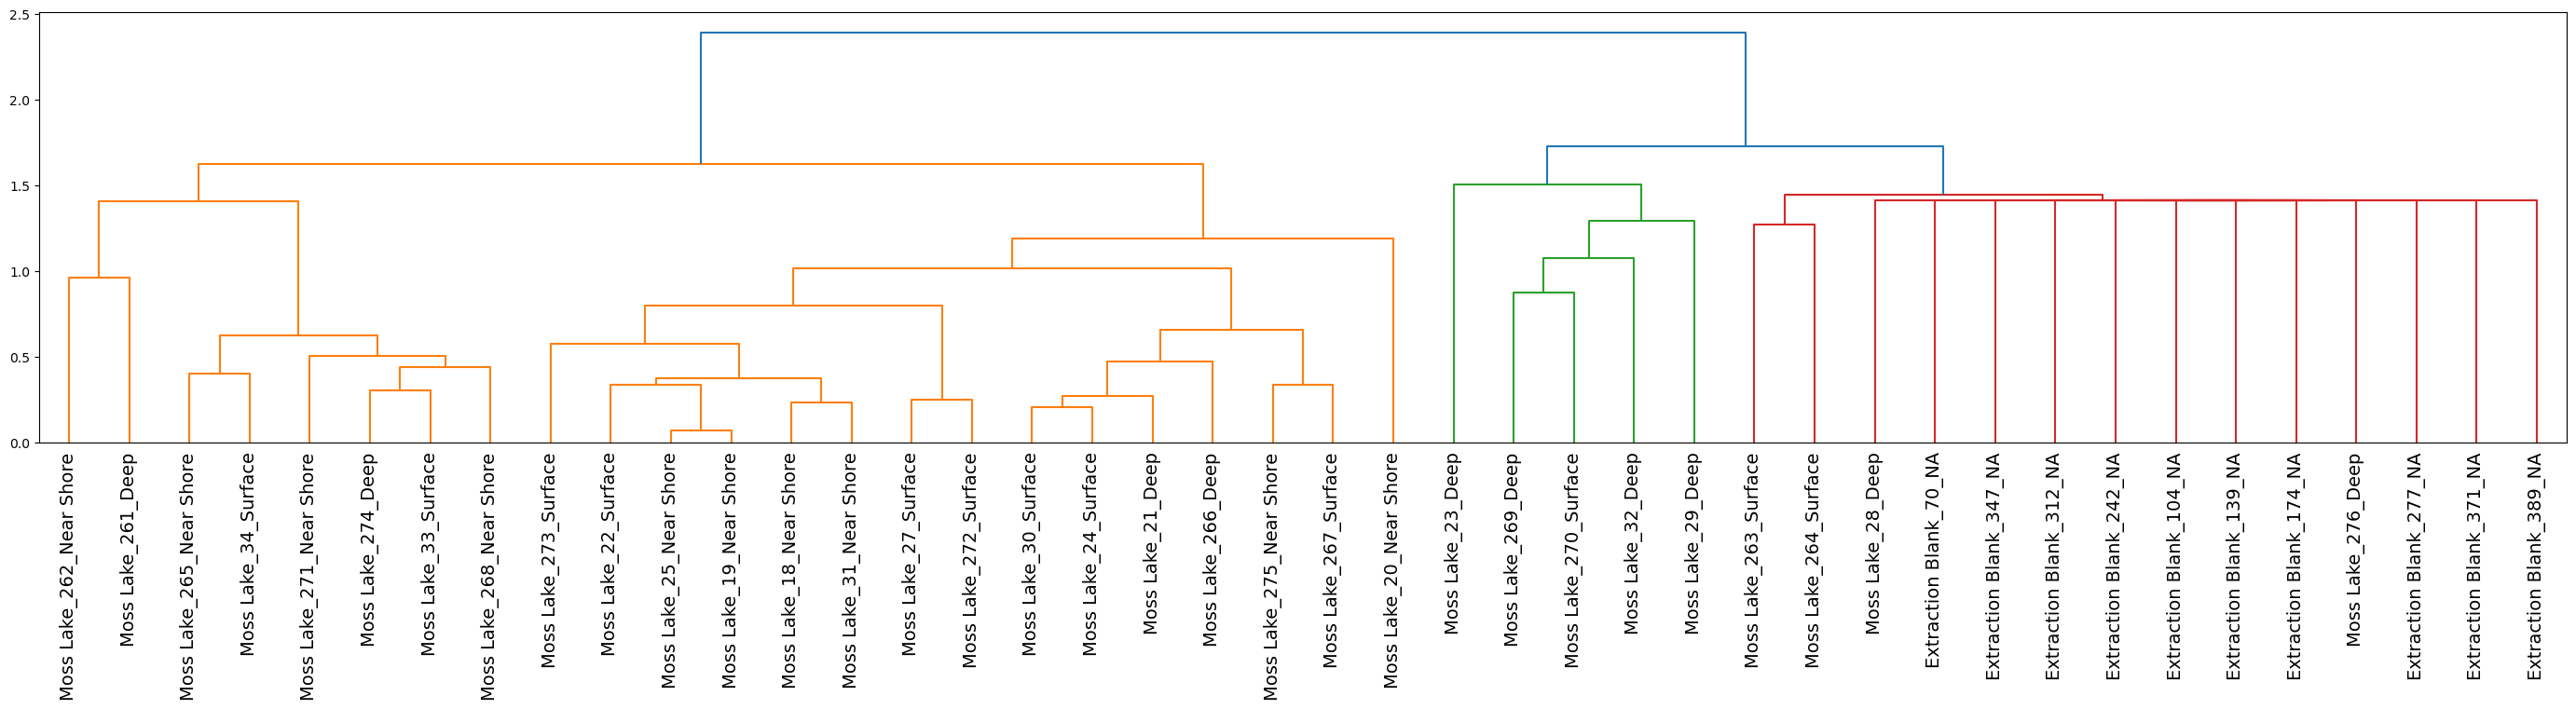

In [163]:
bc_data = bc_data[bc_data.columns[1:-1]].set_index("Name").T
bc_data = bc_data.fillna(0)
ids = bc_data.columns.tolist()
data = []
for samp in ids:
    #bc_data[samp] = bc_data[samp] / bc_data[samp].sum() ##Scale to 0 to 1 per samples
    #bc_data.loc[bc_data[samp] > 0, samp] = 1 ##Scale into binary for each sample
    tmp = bc_data[samp].tolist()
    data = data + [tmp]
bc_dm = beta_diversity("braycurtis", data, ids)
bc_dm_data = pd.DataFrame(bc_dm.data)
imputer = SimpleImputer(strategy = "most_frequent")
out = imputer.fit_transform(bc_dm_data)
bc_dm_data = pd.DataFrame(out, index=bc_dm_data.index, columns=bc_dm_data.columns)
bc_dm_data = bc_dm_data.to_numpy()
plt.figure(figsize=(35, 6))
Z = hierarchy.linkage(bc_dm_data, "weighted", optimal_ordering = True)
hierarchy.dendrogram(
    Z,
    #leaf_rotation=0.,  # rotates the x axis labels
    leaf_font_size=14.,  # font size for the x axis labels
    labels=bc_dm.ids,
    orientation="top"
)
#plt.savefig("../dendrogram_untransformed_insects.pdf", dpi = 300, bbox_inches='tight')

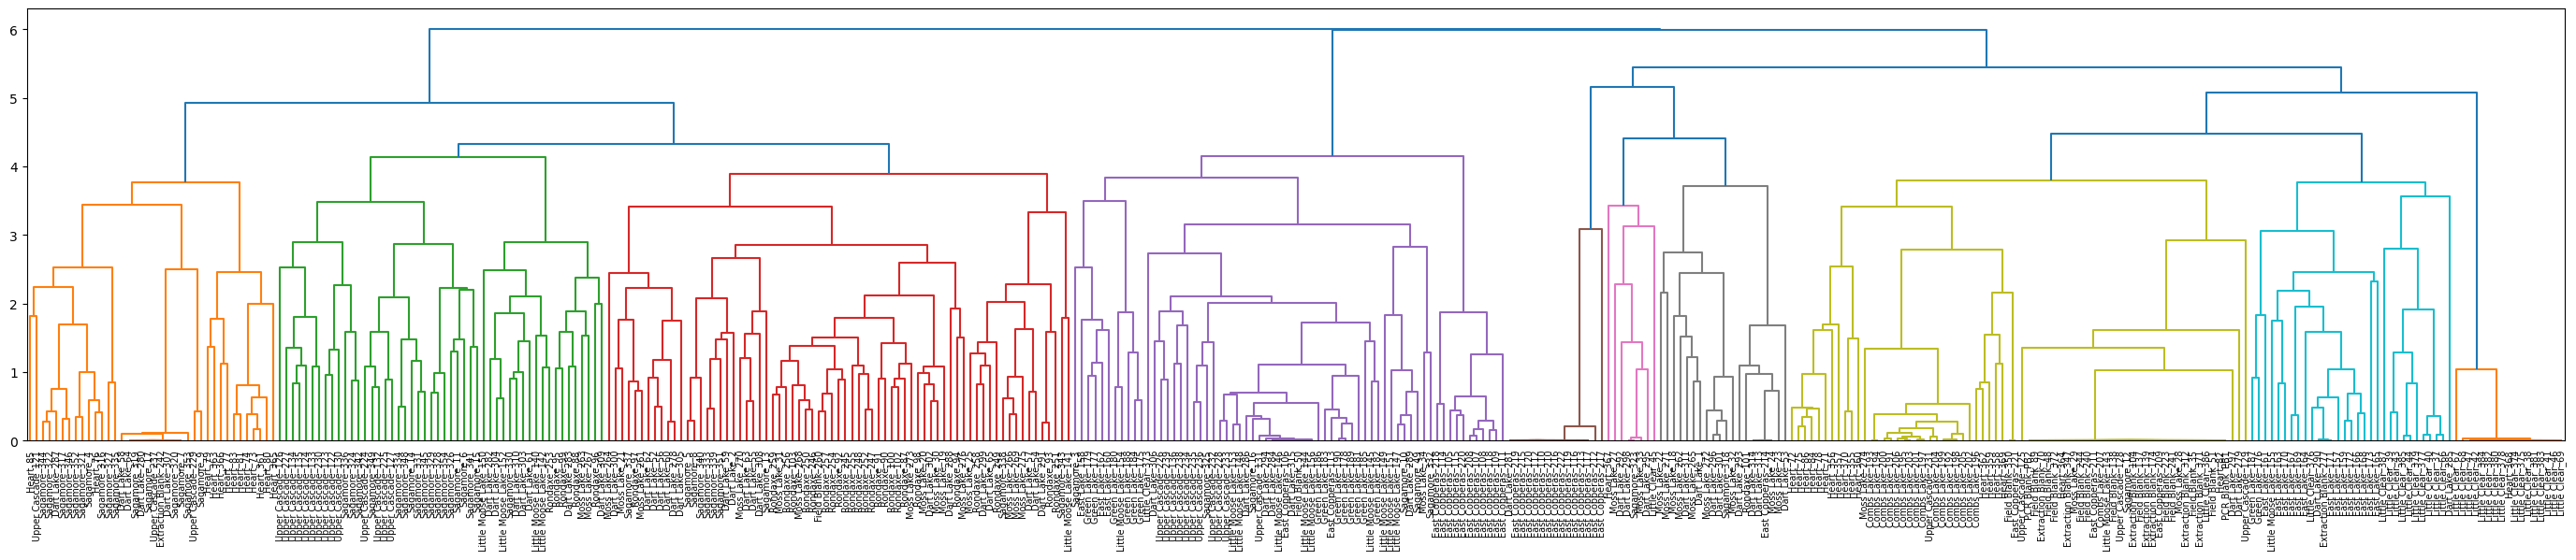

In [127]:
bc_data = asvs.merge(rename, on = "index", how = "left")
#bc_data = bc_data[~bc_data["index"].isin(["PB1", "PB2"])]
bc_data = bc_data[bc_data["Name"].notna()]
bc_data["Name"] = bc_data["Name"] + "_" + bc_data["index"]
bc_data = bc_data[bc_data.columns[1:]].set_index("Name").T
bc_data = bc_data.fillna(0)
ids = bc_data.columns.tolist()
data = []
for samp in ids:
    bc_data[samp] = bc_data[samp] / bc_data[samp].sum() ##Scale to 0 to 1 per samples
    #bc_data.loc[bc_data[samp] > 0, samp] = 1 ##Scale into binary for each sample
    tmp = bc_data[samp].tolist()
    data = data + [tmp]
bc_dm = beta_diversity("braycurtis", data, ids)
bc_dm_data = pd.DataFrame(bc_dm.data)
imputer = SimpleImputer(strategy = "most_frequent")
out = imputer.fit_transform(bc_dm_data)
bc_dm_data = pd.DataFrame(out, index=bc_dm_data.index, columns=bc_dm_data.columns)
bc_dm_data = bc_dm_data.to_numpy()
plt.figure(figsize=(35, 6))
Z = hierarchy.linkage(bc_dm_data, "weighted", optimal_ordering = True)
hierarchy.dendrogram(
    Z,
    #leaf_rotation=0.,  # rotates the x axis labels
    leaf_font_size=7.,  # font size for the x axis labels
    labels=bc_dm.ids,
    orientation="top"
)
plt.savefig("../dendrogram_minmax_scaled.pdf", dpi = 300, bbox_inches='tight')

/tmp/ipykernel_870286/2107183250.py:21: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = hierarchy.linkage(bc_dm_data, "weighted", optimal_ordering = True)


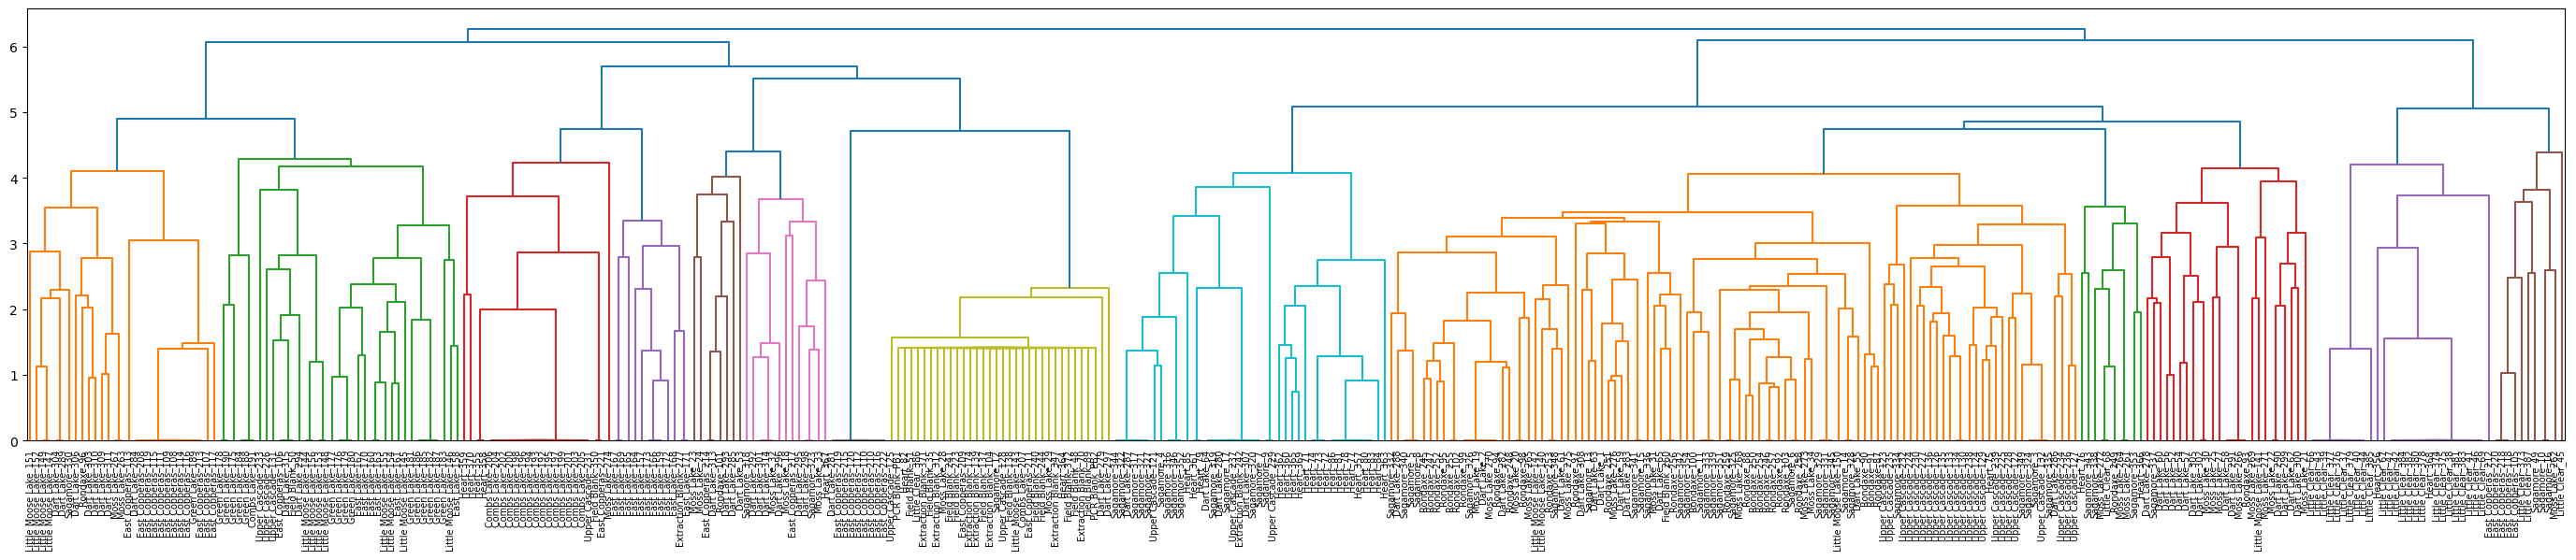

In [128]:
bc_data = asvs.merge(rename, on = "index", how = "left")
#bc_data = bc_data[~bc_data["index"].isin(["PB1", "PB2"])]
bc_data = bc_data[bc_data["Name"].notna()]
bc_data["Name"] = bc_data["Name"] + "_" + bc_data["index"]
bc_data = bc_data[bc_data.columns[1:]].set_index("Name").T
bc_data = bc_data.fillna(0)
ids = bc_data.columns.tolist()
data = []
for samp in ids:
    #bc_data[samp] = bc_data[samp] / bc_data[samp].sum() ##Scale to 0 to 1 per samples
    bc_data.loc[bc_data[samp] > 0, samp] = 1 ##Scale into binary for each sample
    tmp = bc_data[samp].tolist()
    data = data + [tmp]
bc_dm = beta_diversity("braycurtis", data, ids)
bc_dm_data = pd.DataFrame(bc_dm.data)
imputer = SimpleImputer(strategy = "most_frequent")
out = imputer.fit_transform(bc_dm_data)
bc_dm_data = pd.DataFrame(out, index=bc_dm_data.index, columns=bc_dm_data.columns)
bc_dm_data = bc_dm_data.to_numpy()
plt.figure(figsize=(35, 6))
Z = hierarchy.linkage(bc_dm_data, "weighted", optimal_ordering = True)
hierarchy.dendrogram(
    Z,
    #leaf_rotation=0.,  # rotates the x axis labels
    leaf_font_size=7.,  # font size for the x axis labels
    labels=bc_dm.ids,
    orientation="top"
)
plt.savefig("../dendrogram_binary_presence.pdf", dpi = 300, bbox_inches='tight')

Applying filter of García-Machado et al. (https://onlinelibrary.wiley.com/doi/full/10.1002/edn3.444). Filter species if they occur in less than 0.001 * sample read count:

In [16]:
joined.columns[2:-29]

Index(['100', '101', '102', '103', '104', '105', '106', '107', '108', '109',
       ...
       '92', '93', '94', '95', '96', '97', '98', '99', 'PB1', 'PB2'],
      dtype='object', length=387)

In [17]:
persample = pd.DataFrame()
for samp in joined.columns[2:-29]:
    tmp = pd.DataFrame(joined[[samp, "Overall_Best", "Genus"]].groupby(['Overall_Best', 
                                                                     "Genus"])[samp].sum())
    tmp = tmp[tmp[samp] > (tmp[samp].sum() * 0.001)].reset_index(drop=False)
    tmp.columns = ["Overall_Best", "Genus", "Read_Counts"]
    tmp["Sample"] = samp
    persample = pd.concat([persample, tmp]).reset_index(drop=True)

In [ ]:
metadata["EGCF-ID"][metadata["Name"] == "Li"]

In [138]:
lake = "Little Moose Lake"
networkdata = per
networkdata = networkdata[networkdata.columns[2:-24].tolist() + ["Overall_Best"]]
networkdata = networkdata.groupby(['Overall_Best']).sum().reset_index(drop=False)
networkdata = networkdata[["Overall_Best"] + 
            [i for i in networkdata.columns.tolist() if i in 
             metadata["EGCF-ID"][metadata["Name"] == lake].tolist()]]

NameError: name 'per' is not defined

In [68]:
lake = "Upper Cascade"
metadata["EGCF-ID"][metadata["Name"] == lake].tolist()[0]

'121'

In [69]:
fish = fish[fish["Overall_Best"].notna()].reset_index(drop=True)

In [74]:
test = fish[metadata["EGCF-ID"][metadata["Name"] == lake].tolist() + ["Overall_Best"]][fish["Overall_Best"].str.contains("Prosopium cylindraceum")].set_index("Overall_Best").T.reset_index(drop=False)

In [76]:
test.columns = ["EGCF-ID"] + test.columns[1:].tolist()

In [77]:
test.merge(metadata[["EGCF-ID", "Description", "Water Depth", "eDNA Depth (m)"]], how = "left", on = "EGCF-ID")

EGCF-ID  Prosopium cylindraceum Description  Water Depth  eDNA Depth (m)
0      121                 62748.0        Deep         11.4             8.0
1      122                     0.0  Near Shore          2.0             0.0
2      123                     0.0     Surface         11.4             0.0
3      124                     0.0  Near Shore          2.0             0.0
4      125                127937.0        Deep         16.0            12.0
5      126                     0.0     Surface         16.0             0.0
6      127                     0.0  Near Shore          4.0             0.0
7      128                     0.0        Deep         19.0            12.0
8      129                    41.0     Surface         19.0             0.0
9      130                     0.0  Near Shore          3.0             0.0
10     131                     0.0        Deep         20.5            12.0
11     132                     0.0     Surface         20.5             0.0
12     133                     0.0  Near Shore          1.0             0.0
13     134                     0.0        Deep          9.8             7.0
14     135                     0.0     Surface          9.8             0.0
15     136                     0.0     Surface          NaN             0.0
16     224                     0.0     Surface          9.8             0.0
17     225                     0.0        Deep          9.8             7.0
18     226                     0.0  Near Shore          0.8             0.0
19     227                     0.0     Surface         21.2             0.0
20     228                     0.0  Near Shore          1.8             0.0
21     229                     0.0        Deep         21.2            12.0
22     230                     0.0     Surface         20.6             0.0
23     231                     0.0        Deep         20.6            12.0
24     232                     0.0  Near Shore          1.6             0.0
25     233                     0.0     Surface         16.2             0.0
26     234                 78626.0        Deep         16.2            12.0
27     235                     0.0  Near Shore          1.7             0.0
28     236                     0.0     Surface          9.2             0.0
29     237                     0.0        Deep          9.2             7.0
30     238                     0.0  Near Shore          1.0             0.0
31     239                     0.0     Surface          1.0             0.0

In [59]:
metadata[metadata["EGCF-ID"].isin(["154", "155"])]

Name       Date      Season  ALSC Time Site Description  \
151  Little Moose Lake  8/26/2023  Early Fall     1  NaN    4        Deep   
152  Little Moose Lake  8/26/2023  Early Fall     1  NaN    5        Deep   

    EGCF-ID Replicate   Latitude     Longitude  Water Depth eDNA  \
151     154       NaN  43.694659  -74.91815798          NaN  NaN   
152     155       NaN  43.688471  -74.93298498          NaN  NaN   

     Vol. Filtered (ml)  eDNA Depth (m)  Temp at Depth  DO at Depth  \
151               150.0            20.0            5.5         9.27   
152               150.0            20.0            5.5         9.27   

     Secchi Depth (M)                  Notes  
151               NaN  Secchi data elsewhere  
152               NaN  Secchi data elsewhere

In [73]:
metadata["EGCF-ID"] = metadata["EGCF-ID"].astype(str)

In [75]:
test = fish[metadata["EGCF-ID"][metadata["Name"] == lake].tolist() + ["Overall_Best"]][fish["Overall_Best"].str.contains("Micropterus dolomieu|Chrosomus eos")].set_index("Overall_Best").T


In [77]:
test = fish[metadata["EGCF-ID"][metadata["Name"] == lake].tolist() + ["Overall_Best"]][fish["Overall_Best"].str.contains("Micropterus dolomieu|Chrosomus eos")].set_index("Overall_Best").T.reset_index(drop=False)
test.columns = ["EGCF-ID"] + test.columns[1:].tolist()
test["EGCF-ID"] = test["EGCF-ID"].astype(str)

In [79]:
test.merge(metadata[["EGCF-ID", "Description", "eDNA Depth (m)"]], how = "left", on = "EGCF-ID")

EGCF-ID  Micropterus dolomieu  Chrosomus eos Description  eDNA Depth (m)
0      140               52704.0            0.0   Nearshore             0.0
1      141               47319.0            0.0   Nearshore             0.0
2      142               27101.0            0.0     Surface             0.0
3      143                   0.0            0.0       Blank             NaN
4      144                   0.0            0.0     Surface             0.0
5      145                   0.0         9941.0        Deep            20.0
6      146                   0.0            0.0        Deep            20.0
7      147               25177.0            0.0     Surface             0.0
8      148                   0.0            0.0     Surface             0.0
9      149               44805.0            0.0     Surface             0.0
10     150               24804.0            0.0   Nearshore             0.0
11     151               32581.0            0.0   Nearshore             0.0
12     152               76967.0            0.0   Nearshore             0.0
13     153                   0.0            0.0     Surface             0.0
14     154                   0.0         5311.0        Deep            20.0
15     155                   0.0         9267.0        Deep            20.0
16     156                   0.0            0.0        Deep            20.0

In [242]:
lake = "Little Moose Lake"
networkdata = asv[asv["Overall_Best_Taxonomic_Level"] == "Species"].reset_index(drop=True)
networkdata = networkdata[networkdata.columns[2:-24].tolist() + ["Overall_Best"]]
networkdata = networkdata.groupby(['Overall_Best']).sum().reset_index(drop=False)
networkdata = networkdata[["Overall_Best"] + 
            [i for i in networkdata.columns.tolist() if i in 
             metadata["EGCF-ID"][metadata["Name"] == lake].tolist()]]

In [ ]:
lake = "Little Moose Lake"
networkdata = asv[asv["Overall_Best_Taxonomic_Level"] == "Species"].reset_index(drop=True)
networkdata = networkdata[networkdata.columns[2:-24].tolist() + ["Overall_Best"]]
networkdata = networkdata.groupby(['Overall_Best']).sum().reset_index(drop=False)
networkdata = networkdata[["Overall_Best"] + 
            [i for i in networkdata.columns.tolist() if i in 
             metadata["EGCF-ID"].tolist()]]

In [243]:
for samp in networkdata.columns[1:]:
    networkdata.loc[networkdata[samp] < (networkdata[samp].sum() * 0.001), samp] = 0

In [244]:
networkdata = networkdata.set_index("Overall_Best").T

In [245]:
co_occurrence = networkdata.T.dot(networkdata)
co_occurrence = co_occurrence.where(co_occurrence != 0, 0)

In [246]:
G = nx.from_pandas_adjacency(co_occurrence)

In [247]:
G.remove_nodes_from(list(nx.isolates(G)))

In [248]:
G.remove_edges_from(list(nx.selfloop_edges(G)))

In [249]:
communities = nx.community.louvain_communities(G)

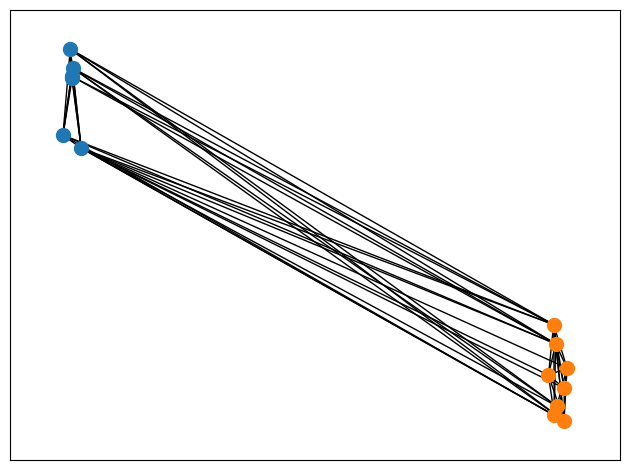

In [251]:
# Compute positions for the node clusters as if they were themselves nodes in a
# supergraph using a larger scale factor
supergraph = nx.cycle_graph(len(communities))
superpos = nx.spring_layout(G, scale=50, seed=429)

# Use the "supernode" positions as the center of each node cluster
centers = list(superpos.values())
pos = {}
for center, comm in zip(centers, communities):
    pos.update(nx.spring_layout(nx.subgraph(G, comm), center=center))

# Nodes colored by cluster
for nodes, clr in zip(communities, ("tab:blue", "tab:orange", "tab:green")):
    nx.draw_networkx_nodes(G, pos=pos, nodelist=nodes, node_color=clr, node_size=100)
nx.draw_networkx_edges(G, pos=pos)

plt.tight_layout()
plt.show()

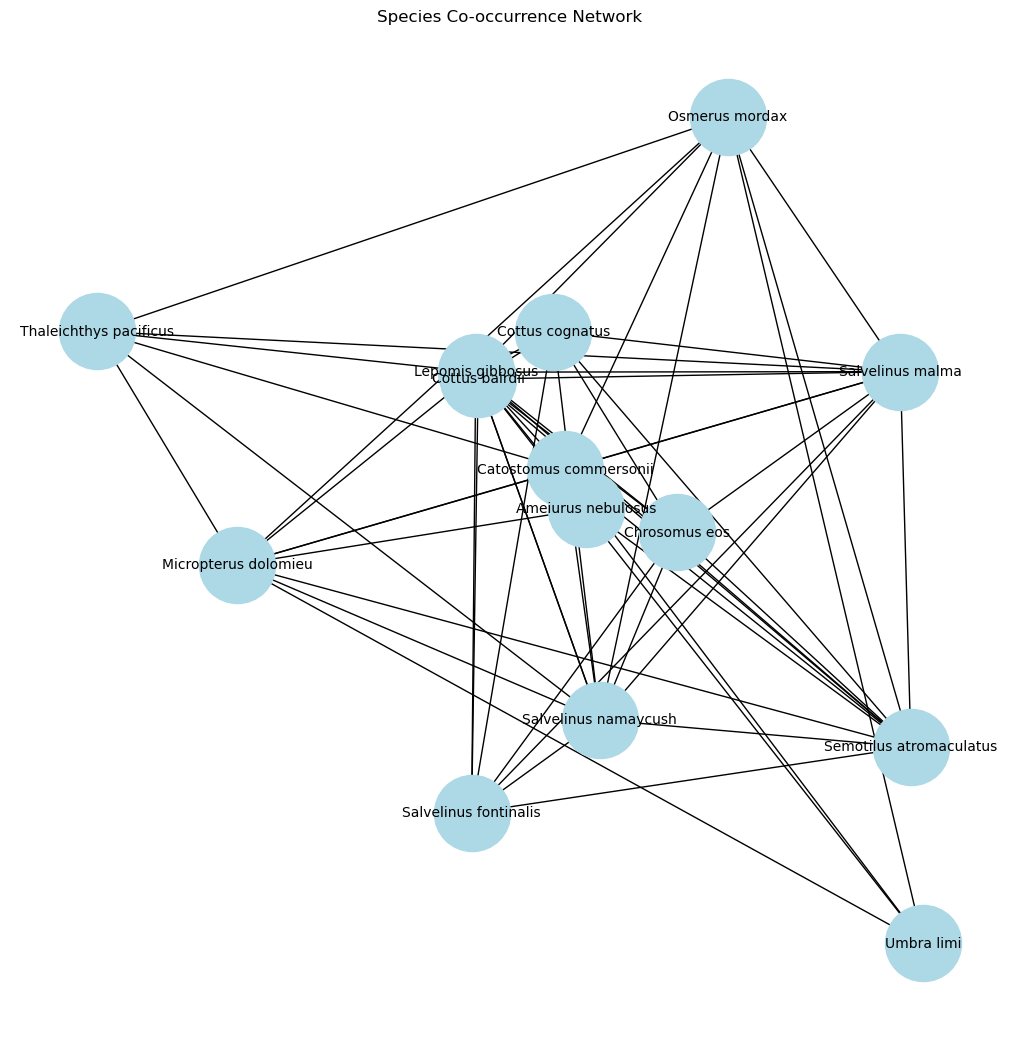

In [252]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph


# Draw the graph
plt.figure(figsize=(10, 10))
pos = nx.random_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', 
        node_size=3000, font_size=10, font_color='black')
plt.title('Species Co-occurrence Network')
plt.show()

In [253]:
degree_dict = dict(G.degree())

In [254]:
sorted_nodes = sorted(degree_dict.items(), key=lambda x: x[1])

# Get least connected nodes
least_connected_nodes = sorted_nodes[:5]  # Change 5 to the number you want
most_connected_nodes = sorted_nodes[-5:]  # Change 5 to the number you want

# Print least connected nodes
print("Least connected nodes:")
for node, degree in least_connected_nodes:
    print(f'Node: {node}, Degree: {degree}')

# Print most connected nodes
print("\nMost connected nodes:")
for node, degree in most_connected_nodes:
    print(f'Node: {node}, Degree: {degree}')

Least connected nodes:
Node: Ameiurus nebulosus, Degree: 4
Node: Umbra limi, Degree: 4
Node: Thaleichthys pacificus, Degree: 6
Node: Chrosomus eos, Degree: 7
Node: Cottus bairdii, Degree: 7

Most connected nodes:
Node: Micropterus dolomieu, Degree: 9
Node: Salvelinus malma, Degree: 11
Node: Salvelinus namaycush, Degree: 11
Node: Semotilus atromaculatus, Degree: 11
Node: Lepomis gibbosus, Degree: 13


In [255]:
import itertools

In [256]:
node_pairs = itertools.combinations(G.nodes, 2)

# Find pairs that never connect
never_connecting_pairs = [(node1, node2) for node1, node2 in node_pairs if not G.has_edge(node1, node2)]

# Print results
print("Pairs of nodes that never connect:")
for pair in never_connecting_pairs:
    print(pair)

Pairs of nodes that never connect:
('Ameiurus nebulosus', 'Chrosomus eos')
('Ameiurus nebulosus', 'Cottus bairdii')
('Ameiurus nebulosus', 'Cottus cognatus')
('Ameiurus nebulosus', 'Osmerus mordax')
('Ameiurus nebulosus', 'Salvelinus fontinalis')
('Ameiurus nebulosus', 'Salvelinus malma')
('Ameiurus nebulosus', 'Salvelinus namaycush')
('Ameiurus nebulosus', 'Thaleichthys pacificus')
('Ameiurus nebulosus', 'Umbra limi')
('Catostomus commersonii', 'Chrosomus eos')
('Catostomus commersonii', 'Cottus bairdii')
('Catostomus commersonii', 'Cottus cognatus')
('Catostomus commersonii', 'Salvelinus fontinalis')
('Chrosomus eos', 'Micropterus dolomieu')
('Chrosomus eos', 'Osmerus mordax')
('Chrosomus eos', 'Thaleichthys pacificus')
('Chrosomus eos', 'Umbra limi')
('Cottus bairdii', 'Micropterus dolomieu')
('Cottus bairdii', 'Osmerus mordax')
('Cottus bairdii', 'Thaleichthys pacificus')
('Cottus bairdii', 'Umbra limi')
('Cottus cognatus', 'Micropterus dolomieu')
('Cottus cognatus', 'Osmerus morda

In [115]:
def network_robustness(G):
    # Initial size of the largest connected component
    initial_lcc_size = len(max(nx.connected_components(G), key=len))
    sizes = [initial_lcc_size]

    # Create a list of nodes sorted by degree (highest first)
    nodes_by_degree = sorted(G.nodes, key=G.degree, reverse=True)

    # Remove nodes one by one and measure the size of the largest connected component
    for node in nodes_by_degree:
        G.remove_node(node)
        current_lcc_size = len(max(nx.connected_components(G), key=len))
        sizes.append(current_lcc_size)

    return sizes

# Calculate robustness
robustness_sizes = network_robustness(G)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(range(len(robustness_sizes)), robustness_sizes, marker='o')
plt.title('Network Robustness Analysis')
plt.xlabel('Number of Nodes Removed')
plt.ylabel('Size of Largest Connected Component')
plt.xticks(range(len(robustness_sizes)))
plt.grid()
plt.show()

ValueError: max() arg is an empty sequence

In [33]:
networkdata = networkdata.set_index("Overall_Best").T.to_dict(orient = "list")

In [34]:
df = pd.DataFrame(networkdata)

In [7]:
data = {
    'Species_A': [1, 1, 0, 1, 0],
    'Species_B': [1, 0, 1, 1, 0],
    'Species_C': [0, 1, 1, 0, 0],
    'Species_D': [1, 1, 1, 0, 1],
}

df = pd.DataFrame(data)

In [8]:
co_occurrence = df.T.dot(df)
co_occurrence = co_occurrence.where(co_occurrence != 0, 0)

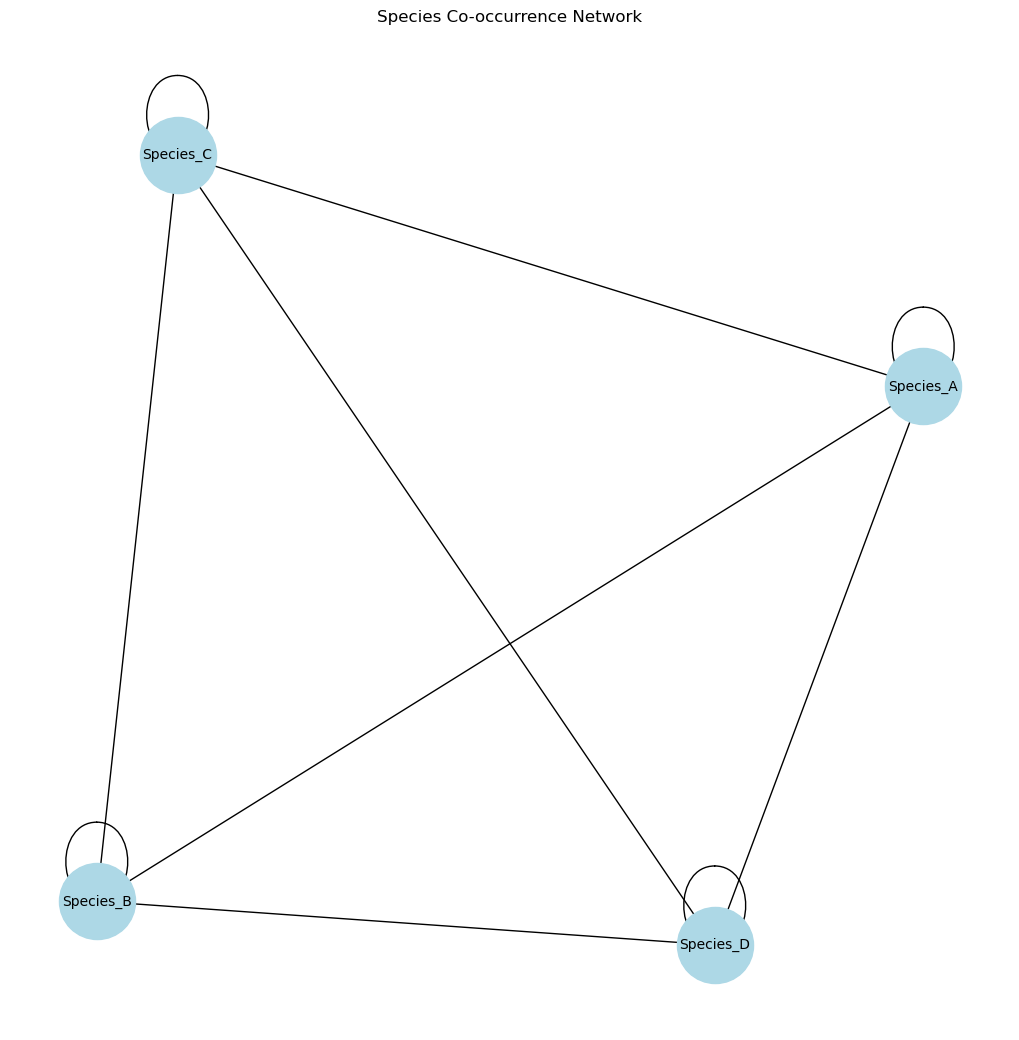

In [9]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph
G = nx.from_pandas_adjacency(co_occurrence)

# Draw the graph
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=3000, font_size=10, font_color='black')
plt.title('Species Co-occurrence Network')
plt.show()

In [10]:
from sklearn.metrics import jaccard_score

species_a = df['Species_A'].values
species_b = df['Species_B'].values

jaccard_index = jaccard_score(species_a, species_b)
print(f'Jaccard Index between Species A and B: {jaccard_index}')

Jaccard Index between Species A and B: 0.5


In [14]:
persample.value_counts("Overall_Best")

Overall_Best
Lepomis                                 173
Catostomus commersonii                  173
Lepomis gibbosus                        171
Micropterus                             116
Perca flavescens                        106
Ameiurus nebulosus                       87
Micropterus salmoides                    86
Semotilus atromaculatus                  80
Salvelinus fontinalis                    76
Ameiurus                                 63
Notemigonus crysoleucas                  62
Micropterus dolomieu                     56
Umbra limi                               50
Chrosomus eos                            49
Chrosomus neogaeus                       37
Rhinichthys atratulus                    32
Umbra                                    31
Ambloplites rupestris                    27
Osmerus mordax                           25
Salvelinus namaycush                     24
Salvelinus malma                         24
Noturus insignis                         22
Fundulus diaphanus 

In [15]:
persample[persample["Overall_Best"] == "Lepomis macrochirus"]

Overall_Best    Genus  Read_Counts Sample
84  Lepomis macrochirus  Lepomis       123501    113
92  Lepomis macrochirus  Lepomis        23549    114

In [12]:
pd.DataFrame((persample[persample["Sample"].isin(metadata["EGCF-ID"]
            [metadata["Name"] == "Heart"].tolist())]
             .groupby(["Overall_Best"])["Read_Counts"].sum())).sort_values("Read_Counts")

Read_Counts
Overall_Best                        
Sus scrofa                       302
Lepomis                          601
Lepomis gibbosus                 996
Micropterus salmoides           8221
Ameiurus                       10351
Rhinichthys atratulus          38798
Micropterus                    55410
Ameiurus nebulosus            103888
Chrosomus eos                 161015
Salvelinus fontinalis         176850
Couesius plumbeus             192220
Semotilus atromaculatus       306101
Chrosomus neogaeus            341701
Catostomus commersonii        573640
Notemigonus crysoleucas      1978059

In [581]:
samps = asv.columns[2:-21].tolist()

In [582]:
asv = asv[asv["Genus"].notna()].reset_index(drop=True)

In [583]:
asv = asv[asv["Class"] == "Actinopteri"].reset_index(drop=True)

In [584]:
asvs = pd.concat([asv.groupby(['Genus'])[samps].transform('sum'), asv[["Genus"]]], axis = 1).drop_duplicates()

In [585]:
asvs = asvs.set_index("Genus").T.reset_index(drop=False)

In [586]:
asvs = asvs.loc[:, (asvs != 0).any(axis=0)]

In [587]:
rename = metadata[["EGCF-ID", "Name"]]
rename.columns = ["index", "Name"]

/tmp/ipykernel_870286/3124207728.py:21: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = hierarchy.linkage(bc_dm_data, "weighted", optimal_ordering = True)


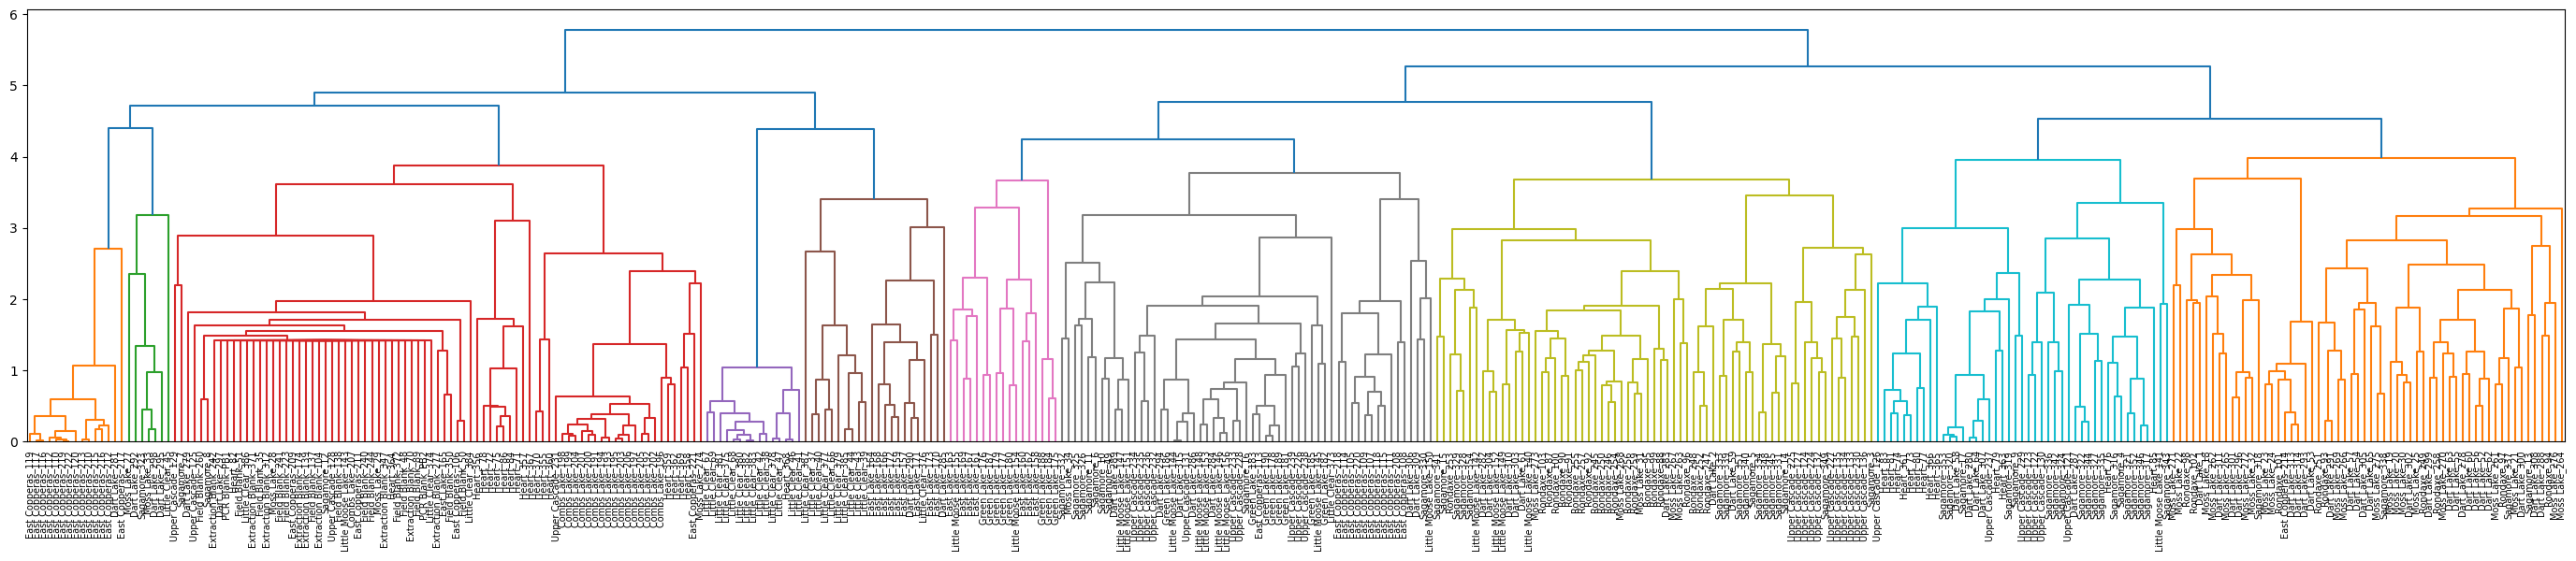

In [126]:
bc_data = asvs.merge(rename, on = "index", how = "left")
#bc_data = bc_data[~bc_data["index"].isin(["PB1", "PB2"])]
bc_data = bc_data[bc_data["Name"].notna()]
bc_data["Name"] = bc_data["Name"] + "_" + bc_data["index"]
bc_data = bc_data[bc_data.columns[1:]].set_index("Name").T
bc_data = bc_data.fillna(0)
ids = bc_data.columns.tolist()
data = []
for samp in ids:
    #bc_data[samp] = bc_data[samp] / bc_data[samp].sum() ##Scale to 0 to 1 per samples
    #bc_data.loc[bc_data[samp] > 0, samp] = 1 ##Scale into binary for each sample
    tmp = bc_data[samp].tolist()
    data = data + [tmp]
bc_dm = beta_diversity("braycurtis", data, ids)
bc_dm_data = pd.DataFrame(bc_dm.data)
imputer = SimpleImputer(strategy = "most_frequent")
out = imputer.fit_transform(bc_dm_data)
bc_dm_data = pd.DataFrame(out, index=bc_dm_data.index, columns=bc_dm_data.columns)
bc_dm_data = bc_dm_data.to_numpy()
plt.figure(figsize=(35, 6))
Z = hierarchy.linkage(bc_dm_data, "weighted", optimal_ordering = True)
hierarchy.dendrogram(
    Z,
    #leaf_rotation=0.,  # rotates the x axis labels
    leaf_font_size=7.,  # font size for the x axis labels
    labels=bc_dm.ids,
    orientation="top"
)
plt.savefig("../dendrogram_untransformed.pdf", dpi = 300, bbox_inches='tight')

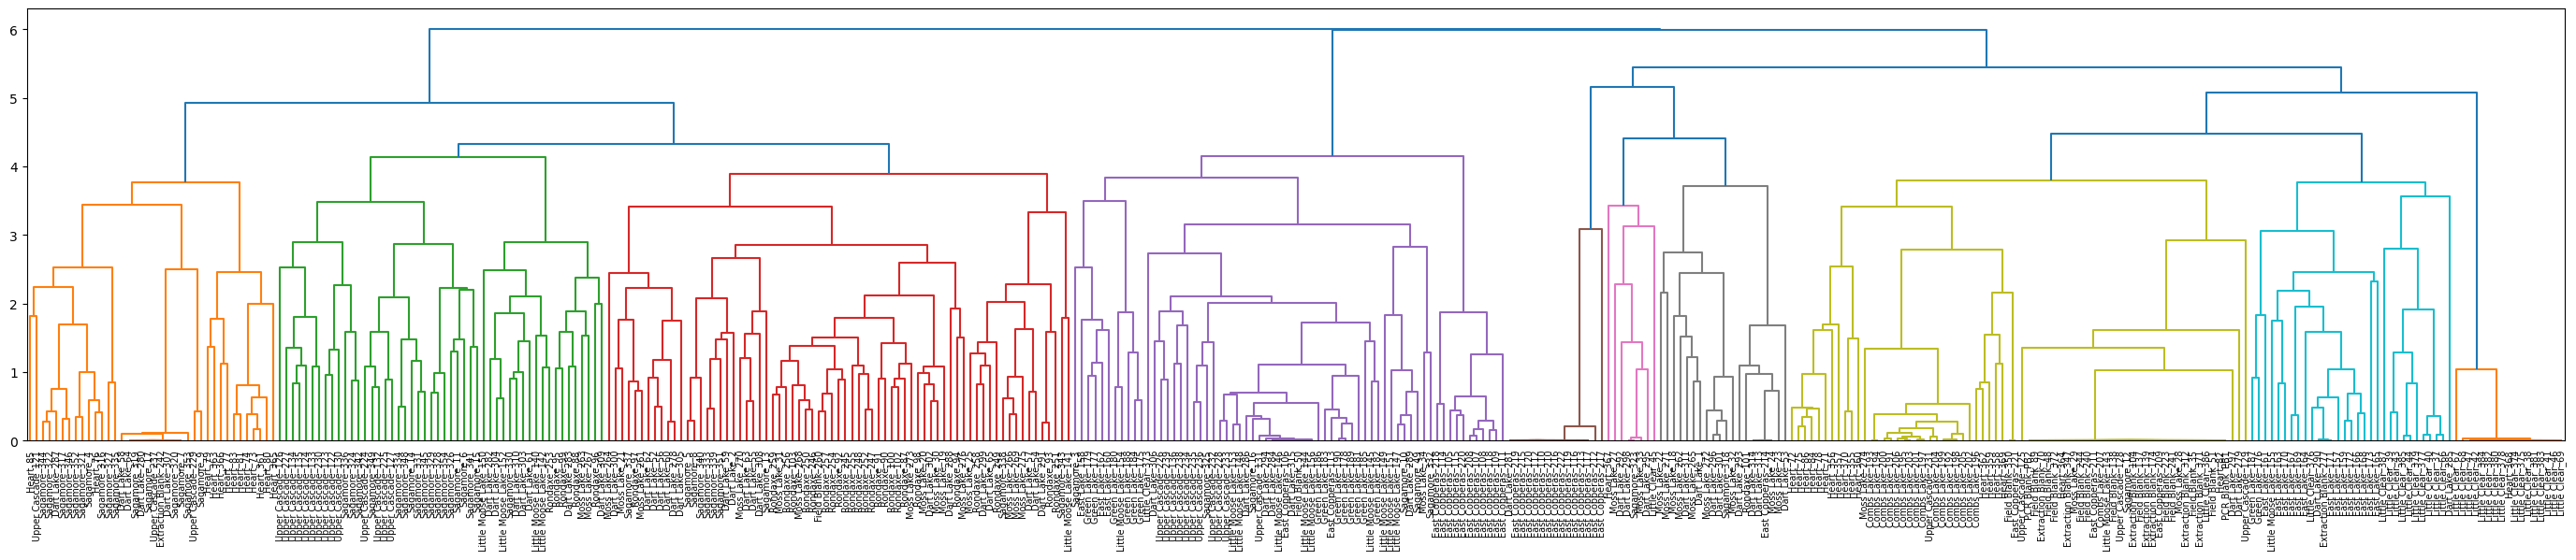

In [127]:
bc_data = asvs.merge(rename, on = "index", how = "left")
#bc_data = bc_data[~bc_data["index"].isin(["PB1", "PB2"])]
bc_data = bc_data[bc_data["Name"].notna()]
bc_data["Name"] = bc_data["Name"] + "_" + bc_data["index"]
bc_data = bc_data[bc_data.columns[1:]].set_index("Name").T
bc_data = bc_data.fillna(0)
ids = bc_data.columns.tolist()
data = []
for samp in ids:
    bc_data[samp] = bc_data[samp] / bc_data[samp].sum() ##Scale to 0 to 1 per samples
    #bc_data.loc[bc_data[samp] > 0, samp] = 1 ##Scale into binary for each sample
    tmp = bc_data[samp].tolist()
    data = data + [tmp]
bc_dm = beta_diversity("braycurtis", data, ids)
bc_dm_data = pd.DataFrame(bc_dm.data)
imputer = SimpleImputer(strategy = "most_frequent")
out = imputer.fit_transform(bc_dm_data)
bc_dm_data = pd.DataFrame(out, index=bc_dm_data.index, columns=bc_dm_data.columns)
bc_dm_data = bc_dm_data.to_numpy()
plt.figure(figsize=(35, 6))
Z = hierarchy.linkage(bc_dm_data, "weighted", optimal_ordering = True)
hierarchy.dendrogram(
    Z,
    #leaf_rotation=0.,  # rotates the x axis labels
    leaf_font_size=7.,  # font size for the x axis labels
    labels=bc_dm.ids,
    orientation="top"
)
plt.savefig("../dendrogram_minmax_scaled.pdf", dpi = 300, bbox_inches='tight')

/tmp/ipykernel_870286/2107183250.py:21: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = hierarchy.linkage(bc_dm_data, "weighted", optimal_ordering = True)


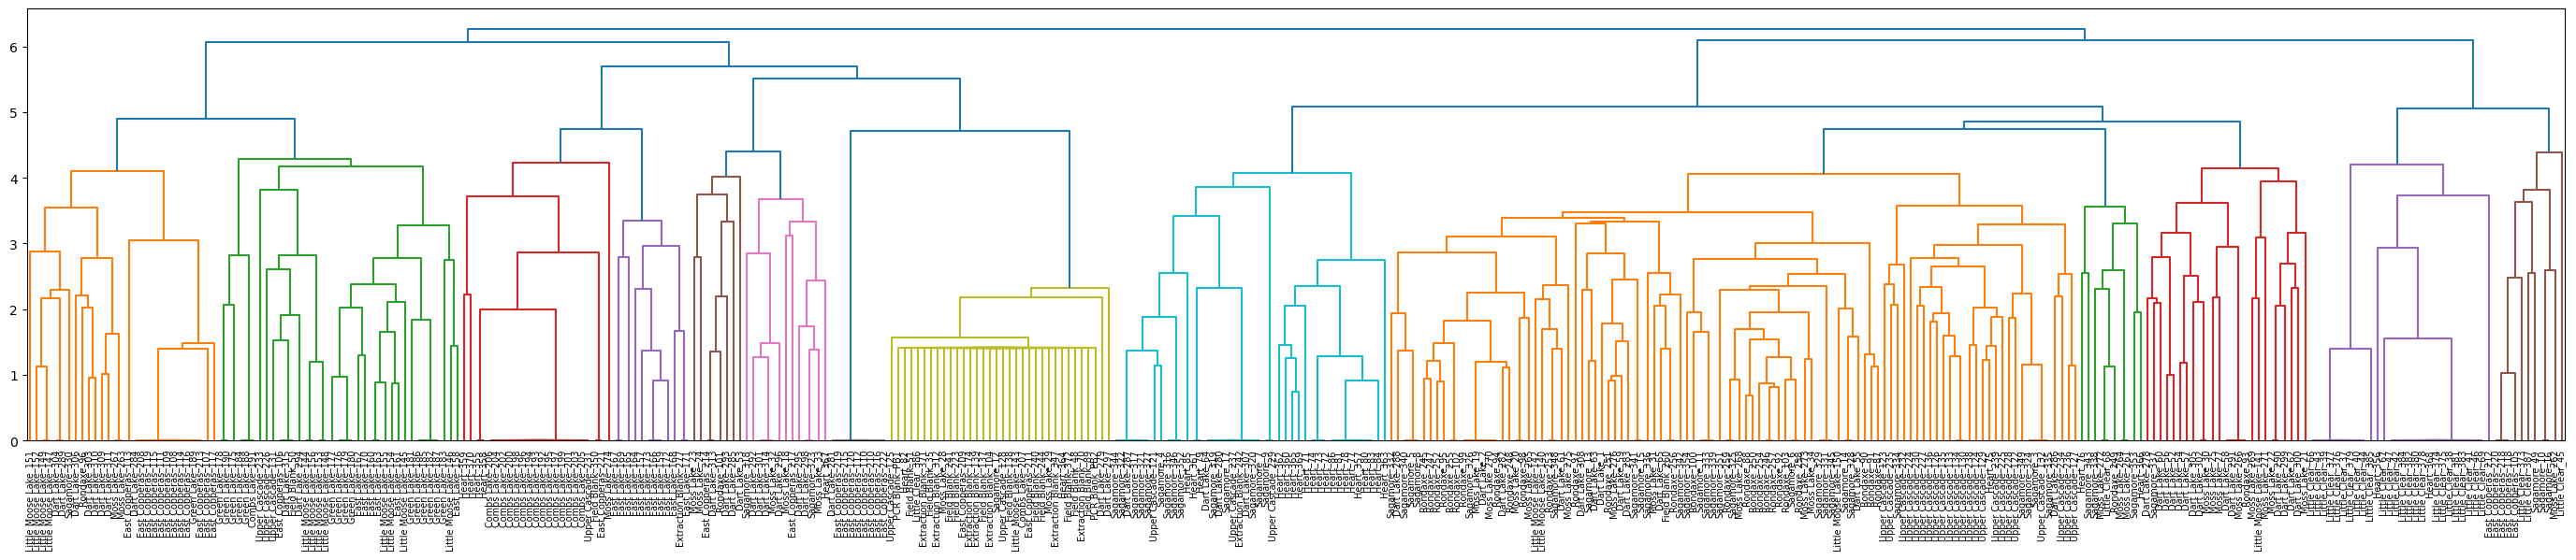

In [128]:
bc_data = asvs.merge(rename, on = "index", how = "left")
#bc_data = bc_data[~bc_data["index"].isin(["PB1", "PB2"])]
bc_data = bc_data[bc_data["Name"].notna()]
bc_data["Name"] = bc_data["Name"] + "_" + bc_data["index"]
bc_data = bc_data[bc_data.columns[1:]].set_index("Name").T
bc_data = bc_data.fillna(0)
ids = bc_data.columns.tolist()
data = []
for samp in ids:
    #bc_data[samp] = bc_data[samp] / bc_data[samp].sum() ##Scale to 0 to 1 per samples
    bc_data.loc[bc_data[samp] > 0, samp] = 1 ##Scale into binary for each sample
    tmp = bc_data[samp].tolist()
    data = data + [tmp]
bc_dm = beta_diversity("braycurtis", data, ids)
bc_dm_data = pd.DataFrame(bc_dm.data)
imputer = SimpleImputer(strategy = "most_frequent")
out = imputer.fit_transform(bc_dm_data)
bc_dm_data = pd.DataFrame(out, index=bc_dm_data.index, columns=bc_dm_data.columns)
bc_dm_data = bc_dm_data.to_numpy()
plt.figure(figsize=(35, 6))
Z = hierarchy.linkage(bc_dm_data, "weighted", optimal_ordering = True)
hierarchy.dendrogram(
    Z,
    #leaf_rotation=0.,  # rotates the x axis labels
    leaf_font_size=7.,  # font size for the x axis labels
    labels=bc_dm.ids,
    orientation="top"
)
plt.savefig("../dendrogram_binary_presence.pdf", dpi = 300, bbox_inches='tight')

In [588]:
bc_data = asvs.merge(rename, on = "index", how = "left")
bc_data = bc_data[bc_data["Name"].notna()]
bc_data["Name"] = bc_data["Name"] + "_" + bc_data["index"]
bc_data = bc_data[bc_data.columns[1:]].set_index("Name").T
bc_data = bc_data.fillna(0)
depth = pd.DataFrame()
for col in bc_data.columns:
    depth = pd.concat([depth, pd.DataFrame([[col, bc_data[col].sum()]])]).reset_index(drop=True)

In [589]:
highcov = depth[0][depth[1] > (depth[1][depth[1] != 0].mean() - (depth[1][depth[1] != 0].std() * 2))].tolist()

In [590]:
bc_data = asvs.merge(rename, on = "index", how = "left")
#bc_data = bc_data[~bc_data["index"].isin(["PB1", "PB2"])]
bc_data = bc_data[bc_data["index"].isin(highcov)].reset_index(drop=True)

In [591]:
lakes = metadata[metadata["Name"].notna()]
lakes = lakes[~lakes["Name"].str.contains("Blank")].reset_index(drop=True)

In [592]:
lake_metadata = pd.read_csv("../lake_metadata.csv")

In [593]:
lake_metadata["LA/SA"] = lake_metadata["Littoral Area (ha)"] / lake_metadata["surface_area (ha)"]

In [594]:
for lake in lakes.Name.unique():
    try:
        bc_data = asvs.merge(rename, on = "index", how = "left")
        #bc_data = bc_data[~bc_data["index"].isin(["PB1", "PB2"])]
        bc_data = (bc_data[bc_data["index"].isin(metadata["EGCF-ID"][metadata["Season"] == "Spring"]
                                                 [metadata["Name"] == lake].tolist())]).reset_index(drop=True)
        bc_data = bc_data[bc_data["Name"].notna()]
        bc_data["Name"] = bc_data["Name"] + "_" + bc_data["index"]
        bc_data = bc_data[bc_data["Name"].isin(highcov)].reset_index(drop=True)
        bc_data = bc_data[bc_data.columns[1:]].set_index("Name").T
        bc_data = bc_data.fillna(0)
        ids = bc_data.columns.tolist()
        data = []
        for samp in ids:
            bc_data[samp] = bc_data[samp] / bc_data[samp].sum() ##Scale to 0 to 1 per samples
            #bc_data.loc[bc_data[samp] > 0, samp] = 1 ##Scale into binary for each sample
            tmp = bc_data[samp].tolist()
            data = data + [tmp]
        bc_dm = beta_diversity("braycurtis", data, ids)
        bc_dm_data = pd.DataFrame(bc_dm.data)
        alldissim = []
        for samp in bc_dm_data.columns:
            alldissim = alldissim + list(set(bc_dm_data[samp][bc_dm_data[samp] != 0].tolist()))
        print(lake, np.median(alldissim))
        lake_metadata.loc[(lake_metadata["Name"] == lake) & (lake_metadata["Season"] == "Spring"), "Mean Bray-Curtis Dissimilarity"] = np.mean(alldissim)
    except:
        pass

Dart Lake 0.4173429954065989
Sagamore 0.5700146662496186
Moss Lake 0.5496515447610635
Little Clear 0.39999136962458626
Heart 0.22191471376433103
Rondaxe 0.35534576875796037
East Copperas 0.32374001118108686
Upper Cascade 0.48070749780044036


In [595]:
for lake in lakes.Name.unique():
    try:
        bc_data = asvs.merge(rename, on = "index", how = "left")
        #bc_data = bc_data[~bc_data["index"].isin(["PB1", "PB2"])]
        bc_data = (bc_data[bc_data["index"].isin(metadata["EGCF-ID"][metadata["Season"] == "Early Fall"]
                                                 [metadata["Name"] == lake].tolist())]).reset_index(drop=True)
        bc_data = bc_data[bc_data["Name"].notna()]
        bc_data["Name"] = bc_data["Name"] + "_" + bc_data["index"]
        bc_data = bc_data[bc_data["Name"].isin(highcov)].reset_index(drop=True)
        bc_data = bc_data[bc_data.columns[1:]].set_index("Name").T
        bc_data = bc_data.fillna(0)
        ids = bc_data.columns.tolist()
        data = []
        for samp in ids:
            bc_data[samp] = bc_data[samp] / bc_data[samp].sum() ##Scale to 0 to 1 per samples
            #bc_data.loc[bc_data[samp] > 0, samp] = 1 ##Scale into binary for each sample
            tmp = bc_data[samp].tolist()
            data = data + [tmp]
        bc_dm = beta_diversity("braycurtis", data, ids)
        bc_dm_data = pd.DataFrame(bc_dm.data)
        alldissim = []
        for samp in bc_dm_data.columns:
            alldissim = alldissim + list(set(bc_dm_data[samp][bc_dm_data[samp] != 0].tolist()))
        print(lake, np.median(alldissim))
        lake_metadata.loc[(lake_metadata["Name"] == lake) & (lake_metadata["Season"] == "Early Fall"), "Mean Bray-Curtis Dissimilarity"] = np.mean(alldissim)
    except:
        pass

Dart Lake 0.6722377726393791
Sagamore 0.5196654524274474
Moss Lake 0.543126282671045
Little Clear 0.5674562753107666
Heart 0.5985659339677407
Rondaxe 0.24696927844564973
East Copperas 0.41648490636655777
Upper Cascade 0.5130864287256816
Little Moose Lake 0.4890479384354702
East Lake 0.3830751939894076
Green Lake 0.3854207151038363
Combs Lake 0.05546017263775066


In [596]:
lake_metadata["thermo_oxy_ratio"] = lake_metadata["thermo_depth"] / lake_metadata["depth.5mgL"] 

In [24]:
def corrfunc(x, y, hue=None, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'r = {r:.2f}, R2 = {r**2:.2f}', xy=(.1, .9), xycoords=ax.transAxes)

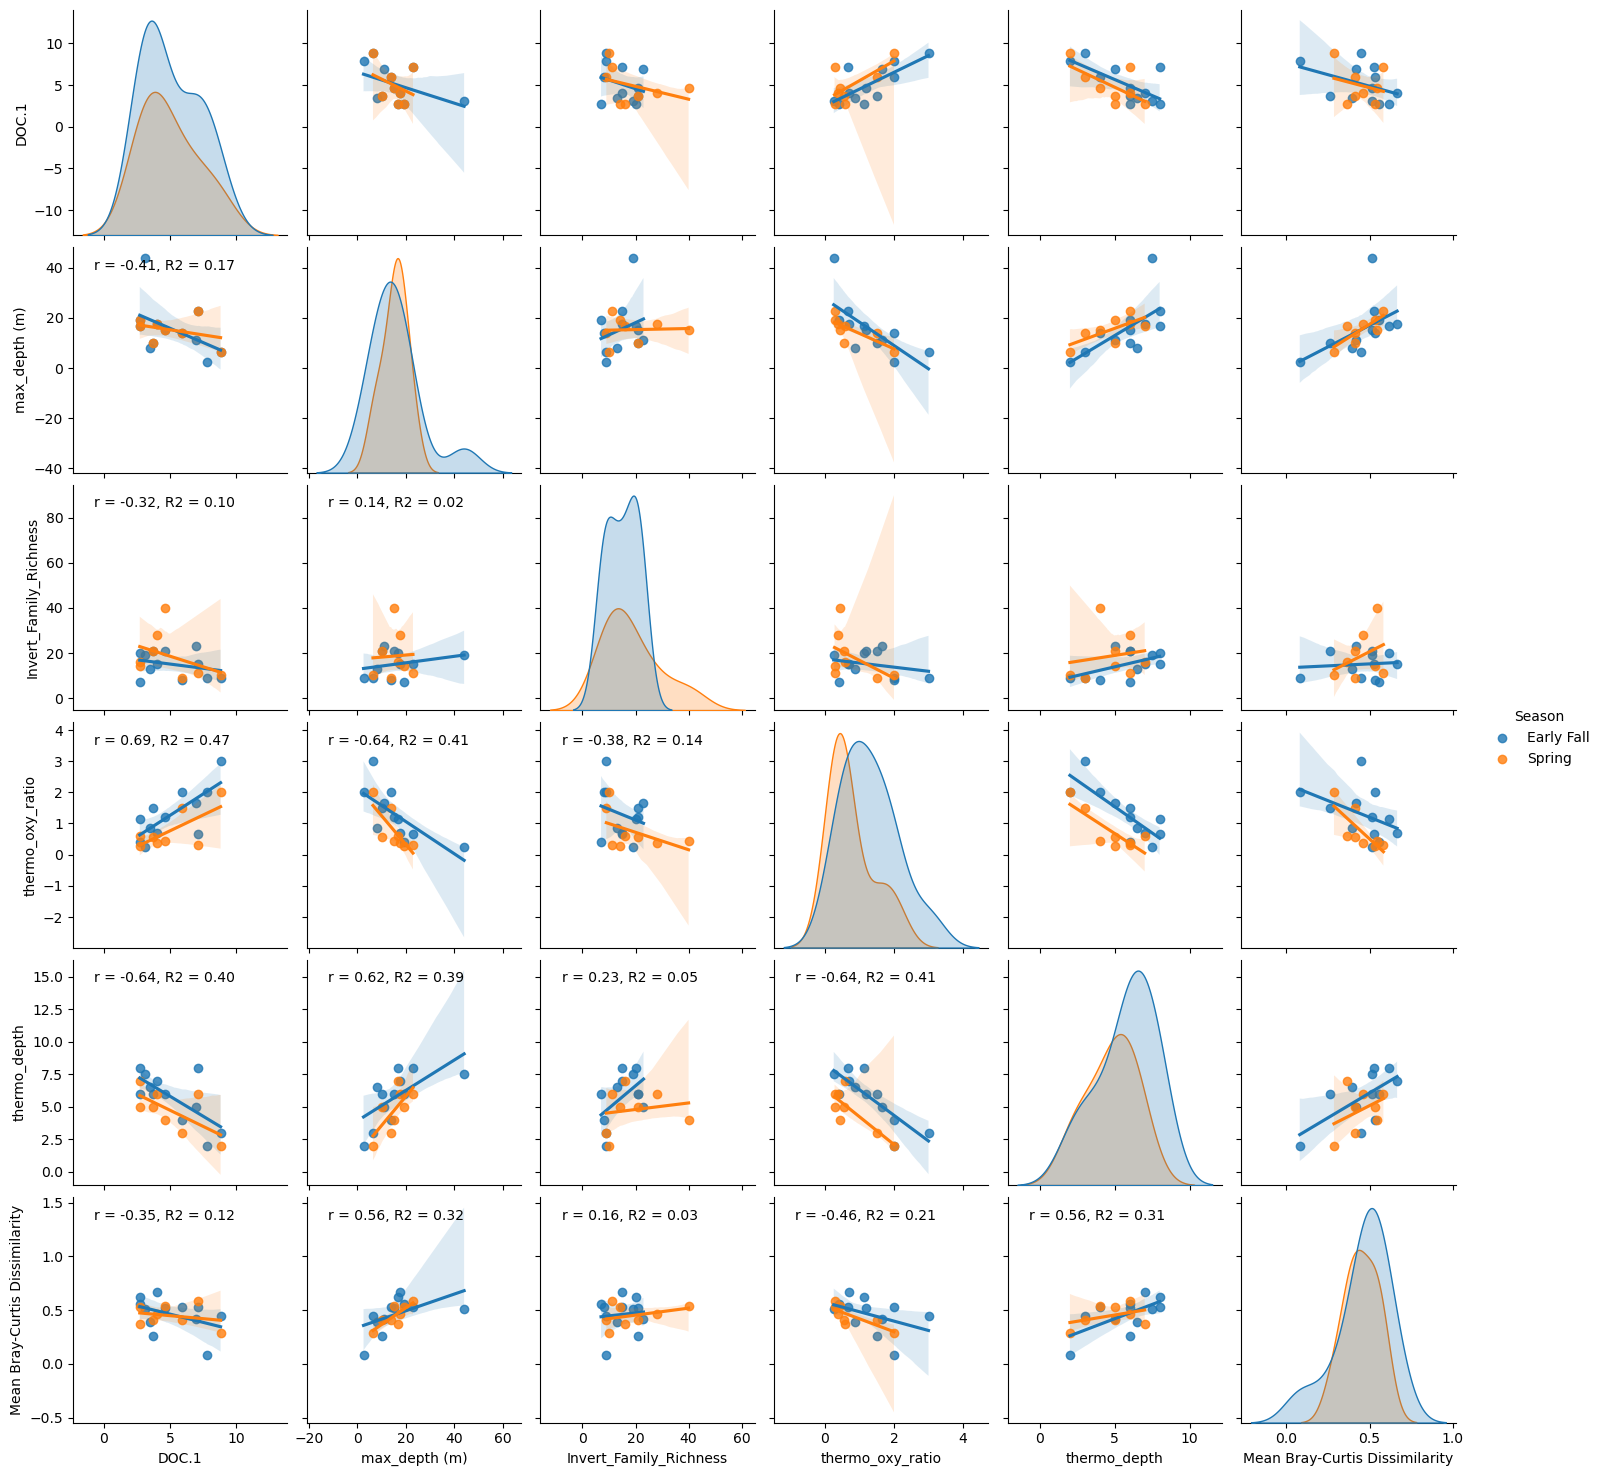

In [ ]:
g = sns.pairplot(lake_metadata[["Name", "DOC.1", 'max_depth (m)', "Invert_Family_Richness",
                                'thermo_oxy_ratio', "thermo_depth",
                                "Mean Bray-Curtis Dissimilarity", "Season"]], 
                 kind="reg", hue = "Season")
g.map_lower(corrfunc)

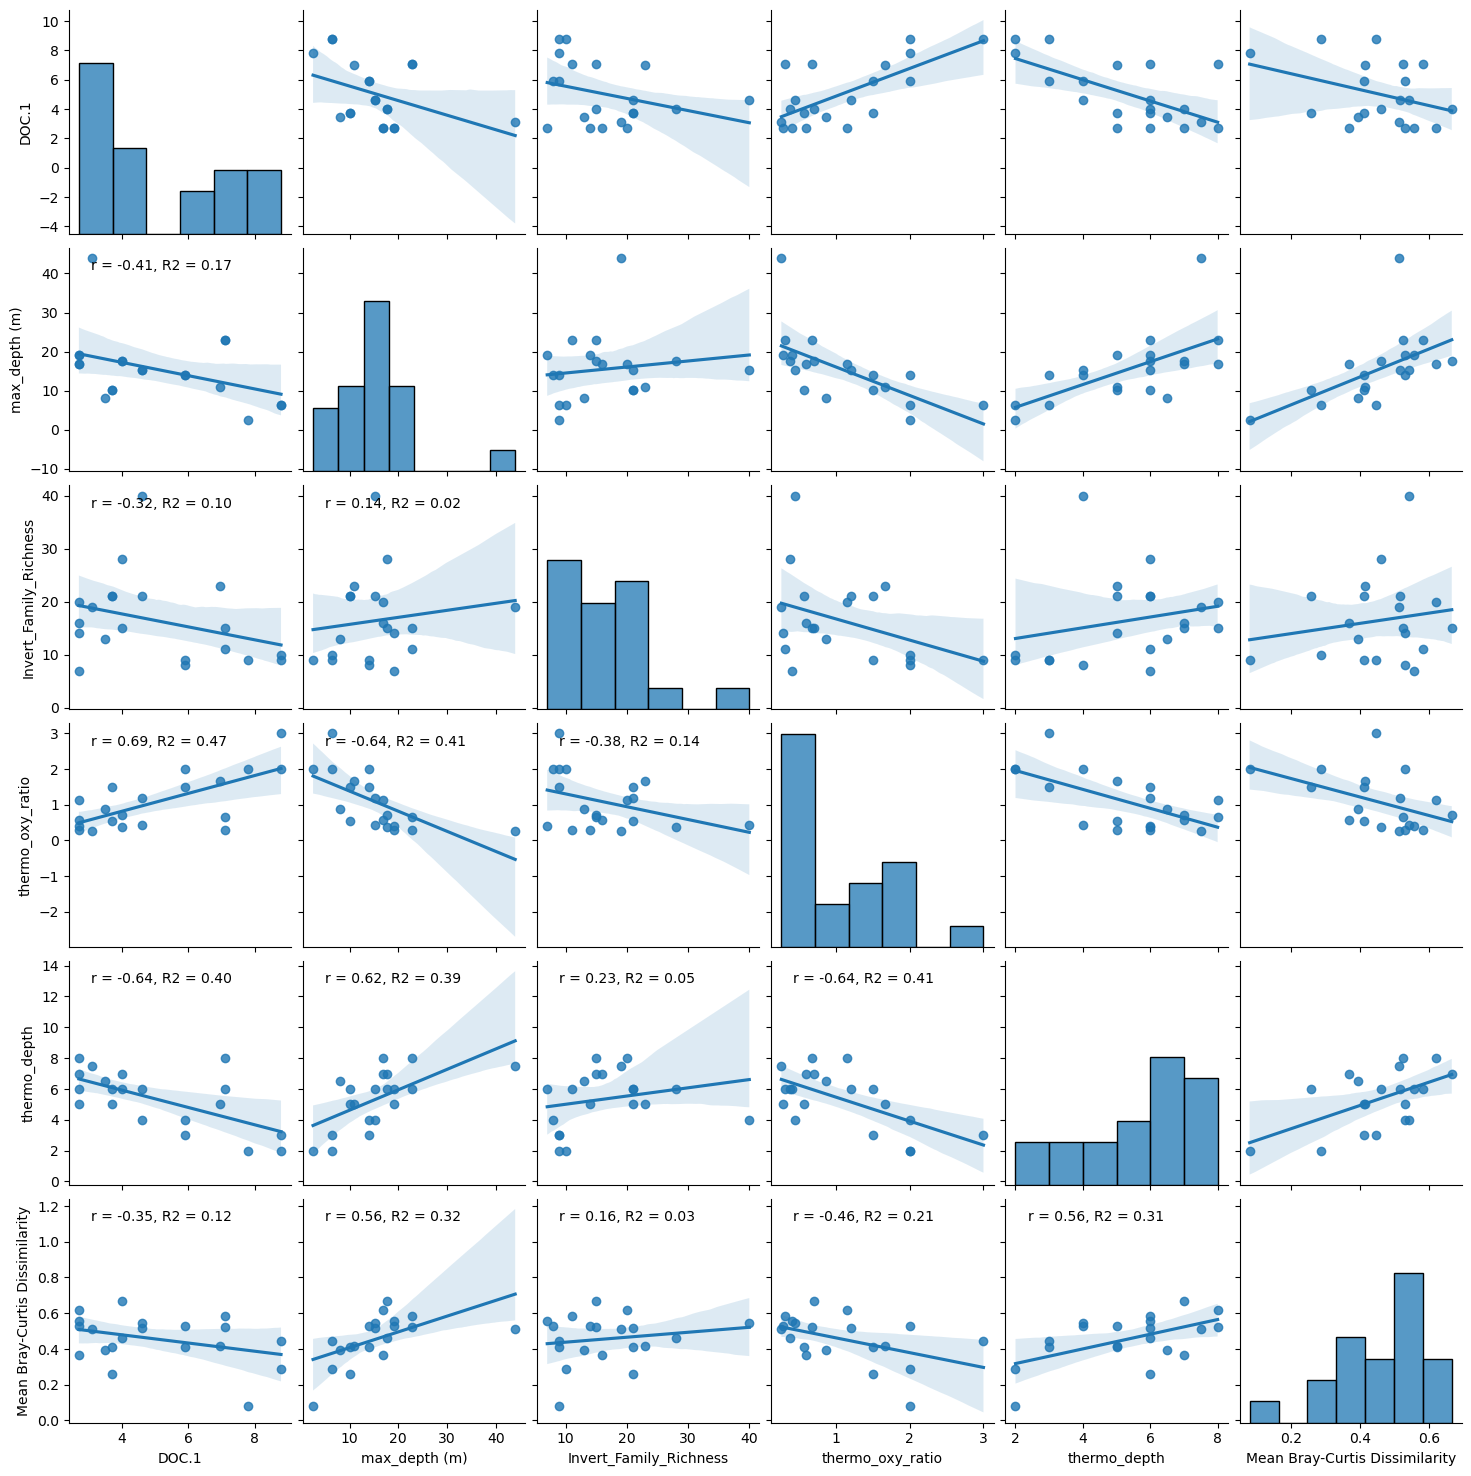

In [ ]:
g = sns.pairplot(lake_metadata[["Name", "DOC.1", 'max_depth (m)', "Invert_Family_Richness",
                                'thermo_oxy_ratio', "thermo_depth",
                                "Mean Bray-Curtis Dissimilarity"]], 
                 kind="reg")
g.map_lower(corrfunc)

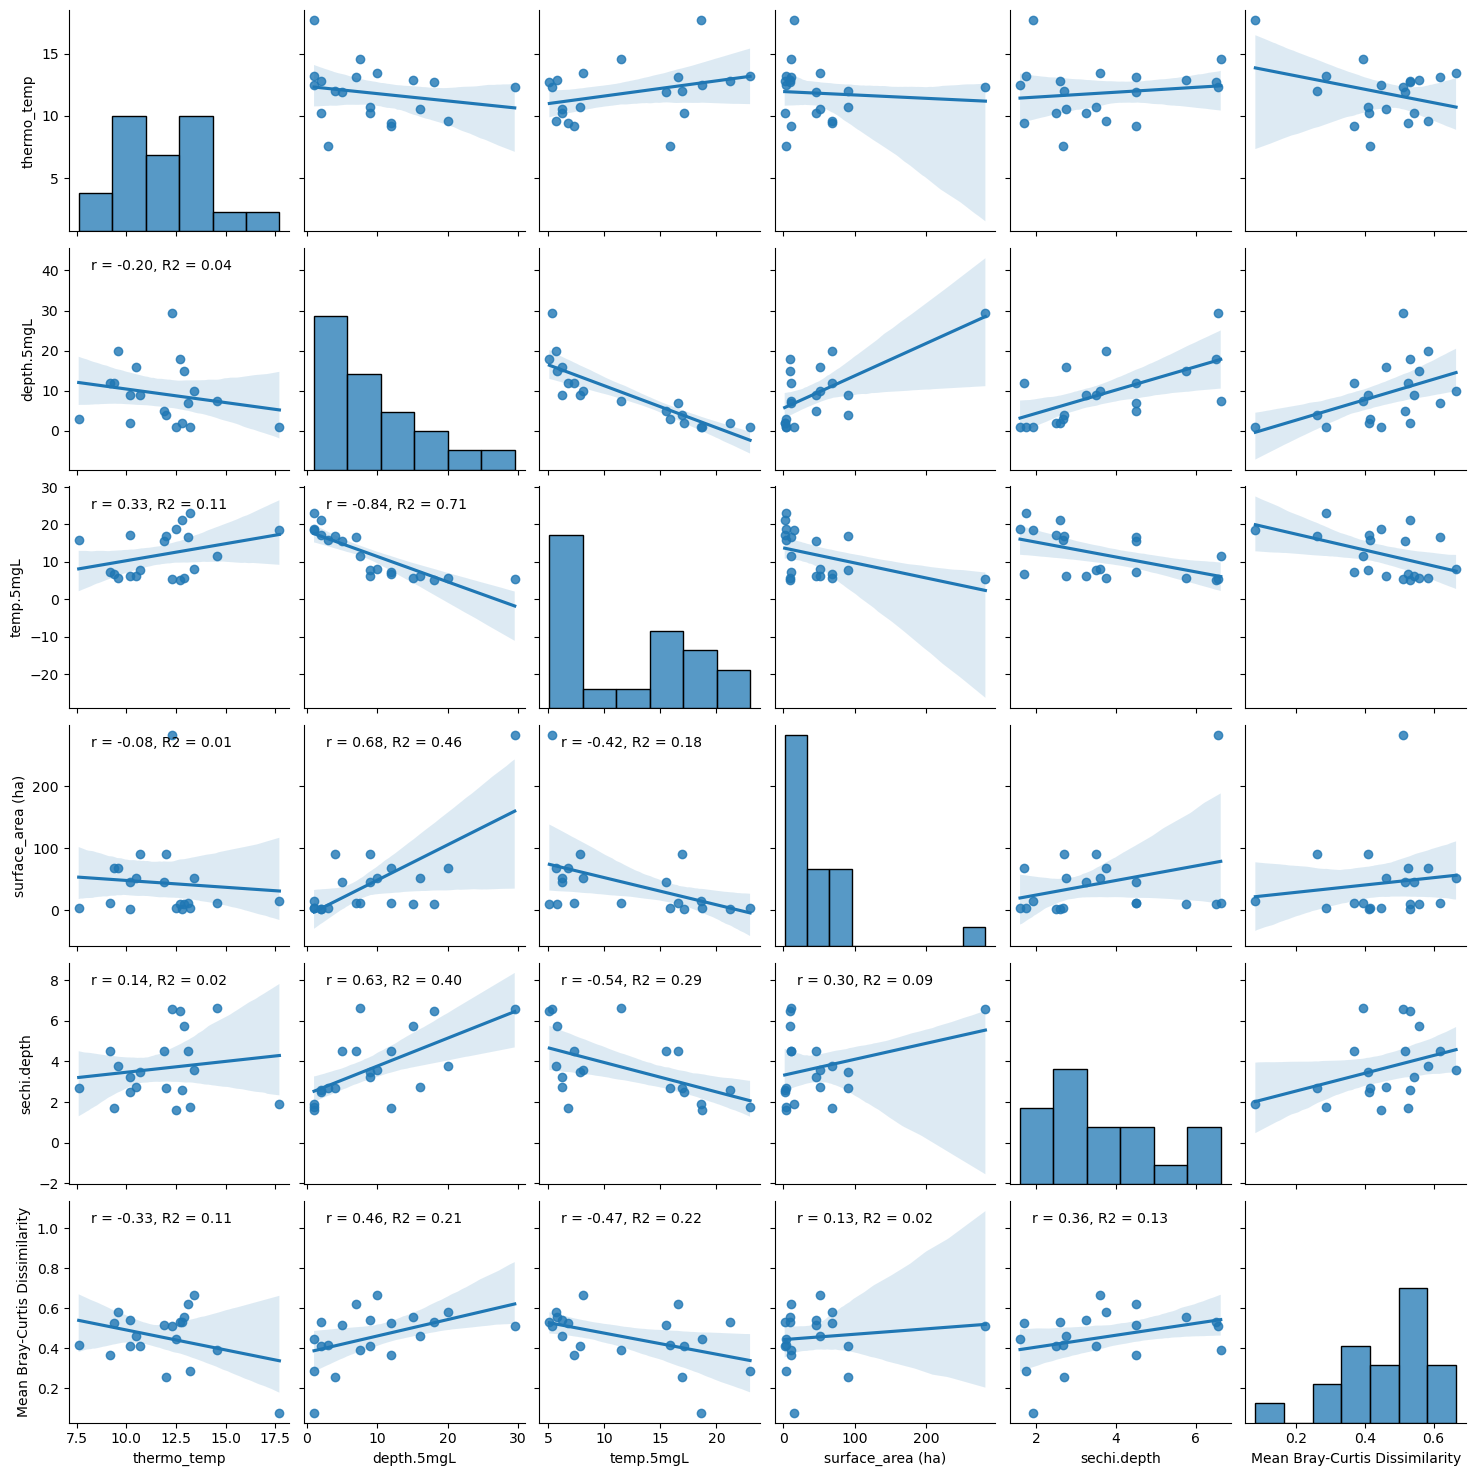

In [26]:
g = sns.pairplot(lake_metadata[["Name", 
                                "thermo_temp", "depth.5mgL", "temp.5mgL", 
                                'surface_area (ha)', "sechi.depth",
                                "Mean Bray-Curtis Dissimilarity"]], 
                 kind="reg")
g.map_lower(corrfunc)

In [78]:
metadata = metadata[metadata["EGCF-ID"].notna()].reset_index(drop=True)
metadata = metadata[metadata["Site"].notna()].reset_index(drop=True)
metadata = metadata[~metadata["Site"].str.contains("Blank")].reset_index(drop=True)

In [106]:
metadata["simpsons_evenness"] = np.nan
for i in range(len(metadata)):
    try:
        tmp = asvs[asvs["index"] == metadata["EGCF-ID"][i]].set_index("index").T
        metadata["simpsons_evenness"][i] = alpha_diversity("simpson_e", tmp[metadata["EGCF-ID"][i]])[0]
    except:
        pass

/tmp/ipykernel_1395417/2878283733.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata["simpsons_evenness"][i] = alpha_diversity("simpson_e", tmp[metadata["EGCF-ID"][i]])[0]
/tmp/ipykernel_1395417/2878283733.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata["simpsons_evenness"][i] = alpha_diversity("simpson_e", tmp[metadata["EGCF-ID"][i]])[0]
/tmp/ipykernel_1395417/2878283733.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

<Axes: xlabel='simpsons_evenness', ylabel='Density'>

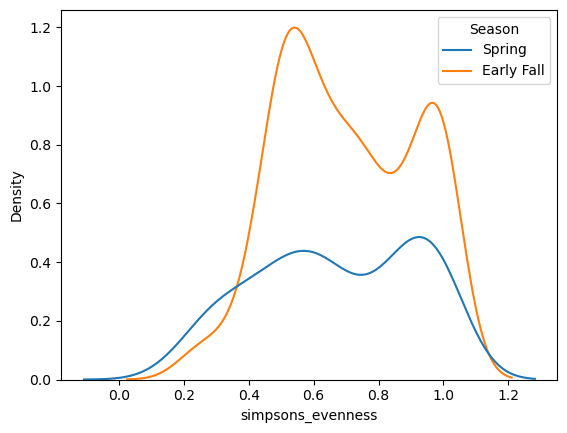

In [113]:
sns.kdeplot(metadata[metadata["simpsons_evenness"] != 0], x = "simpsons_evenness", hue = "Season")

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [118]:
asv = pd.read_csv("../dada2_asv_table_with_taxonomy.csv")

In [119]:
metadata = pd.read_csv("../master_metadata.csv")
metadata.loc[metadata["Site"] == "Blank", "Name"] = "Field Blank"
metadata.loc[metadata["Site"] == "Extraction Blank", "Name"] = "Extraction Blank"
metadata.loc[metadata["Site"] == "PCR Blank", "Name"] = "PCR Blank"

In [120]:
metadata = metadata[metadata["EGCF-ID"].notna()].reset_index(drop=True)

In [121]:
samps = asv.columns[2:-21].tolist()

In [122]:
asv = asv[asv["Best_Hit_Refseq"].notna()].reset_index(drop=True)

In [123]:
asv = asv[asv["Class"] == "Actinopteri"].reset_index(drop=True)

In [124]:
asvs = pd.concat([asv.groupby(['Best_Hit_Refseq'])[samps].transform('sum'), asv[["Best_Hit_Refseq"]]], axis = 1).drop_duplicates()

In [125]:
asvs = asvs.set_index("Best_Hit_Refseq").T.reset_index(drop=False)

In [126]:
asvs = asvs.loc[:, (asvs != 0).any(axis=0)]
cov = asvs.set_index("index").T
coverages = []
for samp in cov.columns:
    coverages = coverages + [cov[samp].sum()]
q1, q3 = np.percentile(coverages, [25, 75])
iqr = q3 - q1
lowcov = np.median(coverages) - (1.5 * iqr)

In [130]:
metadata["Merged"] = metadata["Name"] + "_" + metadata["Season"]

In [131]:
accumulation_curves = pd.DataFrame()
for merge in ["Upper Cascade_Spring"]:
    lake = merge.split("_")[0]
    season = merge.split("_")[1]
    tmp = (asvs[asvs["index"].isin(metadata["EGCF-ID"][metadata["Name"] == lake]
                               [metadata["Season"] == season].tolist())]).set_index("index")
    tmp = tmp.loc[:, (tmp != 0).any(axis=0)]
    tmp['sum'] = tmp.sum(axis=1, numeric_only=True)
    tmp = tmp[tmp["sum"] > lowcov]
    tmp = tmp[tmp.columns[:-1]]

In [150]:
accumulation_curves = pd.DataFrame()
for merge in ["East Lake_Early Fall"]:
    lake = merge.split("_")[0]
    season = merge.split("_")[1]
    tmp = (asvs[asvs["index"].isin(metadata["EGCF-ID"][metadata["Name"] == lake]
                               [metadata["Season"] == season].tolist())]).set_index("index")
    tmp = tmp.loc[:, (tmp != 0).any(axis=0)]
    tmp['sum'] = tmp.sum(axis=1, numeric_only=True)
    tmp = tmp[tmp["sum"] > lowcov]
    tmp = tmp[tmp.columns[:-1]]

In [151]:
tmp.columns

Index(['Lepomis gibbosus', 'Salvelinus fontinalis', 'Semotilus atromaculatus',
       'Salvelinus namaycush', 'Rhinichthys obtusus', 'Chrosomus eos',
       'Osmerus mordax', 'Oncorhynchus'],
      dtype='object', name='Best_Hit_Refseq')

In [152]:
tmp

Best_Hit_Refseq  Lepomis gibbosus  Salvelinus fontinalis  \
index                                                      
157                             0                  73190   
158                         49763                  60413   
159                             0                  73910   
160                         47692                  66732   
161                          5911                  50147   
162                         34984                  17041   
163                         22510                 117326   
164                             0                  62961   
166                             0                  62957   
167                             0                 113759   
168                             0                  46253   
169                             0                  86652   
170                          5047                  20275   
171                             0                  85833   
172                             0                  67011   
173                             0                  30591   

Best_Hit_Refseq  Semotilus atromaculatus  Salvelinus namaycush  \
index                                                            
157                                    0                     0   
158                                    0                     0   
159                                    0                     0   
160                                16008                     0   
161                                47299                     0   
162                                18437                 16376   
163                                24852                     0   
164                                    0                     0   
166                                    0                     0   
167                                65638                     0   
168                                    0                     0   
169                                38863                     0   
170                                 5001                     0   
171                                    0                     0   
172                                    0                     0   
173                                    0                     0   

Best_Hit_Refseq  Rhinichthys obtusus  Chrosomus eos  Osmerus mordax  \
index                                                                 
157                                0              0           20531   
158                            19728              0               0   
159                            19234              0            5304   
160                                0          27378            5106   
161                                0          25459               0   
162                                0              0             189   
163                                0          22727            9201   
164                                0          25715            8589   
166                            32143              0           16747   
167                                0              0               0   
168                            37056              0               0   
169                                0              0               0   
170                             3109              0            2290   
171                                0              0               0   
172                            28302              0             171   
173                            67156              0            3420   

Best_Hit_Refseq  Oncorhynchus  
index                          
157                         0  
158                         0  
159                         0  
160                         0  
161                         0  
162                      4485  
163                         0  
164                         0  
166                         0  
167                         0  
168                         0  
169                         0  
170

In [114]:
tmp['Leuciscidae']

index
224       0
225       0
226       0
227       0
228       0
229       0
230       2
231       0
232       0
233       0
234       0
235       0
236       0
237       0
238    1790
239     585
Name: Leuciscidae, dtype: int64

In [111]:
tmp['Semotilus atromaculatus']

index
224         0
225         0
226         0
227     23701
228      4665
229     41507
230         0
231    122352
232         0
233      5012
234         0
235         0
236         0
237         0
238      1742
239         0
Name: Semotilus atromaculatus, dtype: int64

In [101]:
tmp['Salvelinus fontinalis']

index
121    37156
122    60115
123    39740
124    32511
125        0
126        0
127        0
129    14407
130    59186
131        0
132    29836
133     8742
134    14529
135     8648
136    15488
Name: Salvelinus fontinalis, dtype: int64

In [54]:
tmp.columns

Index(['Lepomis', 'Perca flavescens', 'Lepomis gibbosus', 'Micropterus',
       'Salvelinus fontinalis', 'Catostomus commersonii',
       'Semotilus atromaculatus', 'Umbra', 'Micropterus salmoides',
       'Notemigonus crysoleucas', 'Ameiurus', 'Umbra limi',
       'Chrosomus neogaeus', 'Ambloplites rupestris', 'Chrosomus eos',
       'Micropterus dolomieu', 'Pimephales notatus', 'Fundulus diaphanus',
       'Ambloplites', 'Noturus insignis', 'Ambloplites ariommus',
       'Leuciscidae'],
      dtype='object', name='Best_Hit')

In [622]:
accumulation_curves = pd.DataFrame()
for merge in metadata["Merged"][~metadata["Site"].isin(["PCR Blank", "Blank", "Extraction Blank"])][metadata["Merged"].notna()].unique().tolist():
    lake = merge.split("_")[0]
    season = merge.split("_")[1]
    tmp = (asvs[asvs["index"].isin(metadata["EGCF-ID"][metadata["Name"] == lake]
                               [metadata["Season"] == season].tolist())]).set_index("index")
    tmp = tmp.loc[:, (tmp != 0).any(axis=0)]
    tmp['sum'] = tmp.sum(axis=1, numeric_only=True)
    tmp = tmp[tmp["sum"] > lowcov]
    tmp = tmp[tmp.columns[:-1]]
    shuffles = []
    for shuff in list(range(0,100)):
        tmp1 = tmp.copy()
        for tax in tmp.columns:
            tmp1[tax] = np.random.permutation(tmp[tax].values)
        for nsamps in list(range(1, len(tmp))):
            shuffles = shuffles + [[tmp1.sample(nsamps).agg({'sum'}).astype(bool).sum(axis=1).reset_index(drop=True)[0], nsamps]]
    shuffles = pd.DataFrame(shuffles, columns = ["Number of Species", "Number of Samples"])
    shuffles["Name"] = lake
    shuffles["Season"] = season
    accumulation_curves = pd.concat([accumulation_curves, shuffles]).reset_index(drop=True)

<Axes: xlabel='Number of Samples', ylabel='Number of Species'>

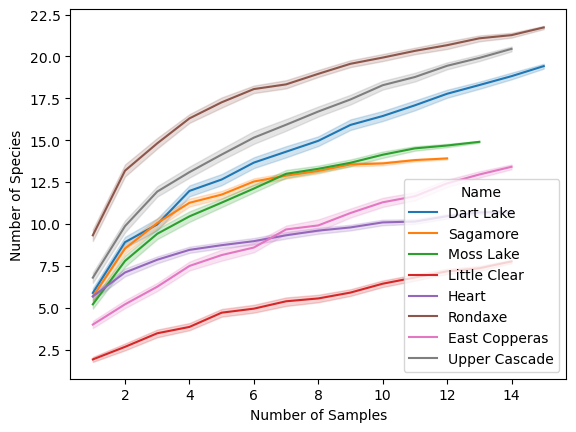

In [624]:
sns.lineplot(data = accumulation_curves[accumulation_curves["Season"] == "Spring"], 
             x = "Number of Samples", y = "Number of Species", 
             estimator=np.mean, errorbar=('ci', 95), hue = "Name")

<Axes: xlabel='Number of Samples', ylabel='Number of Species'>

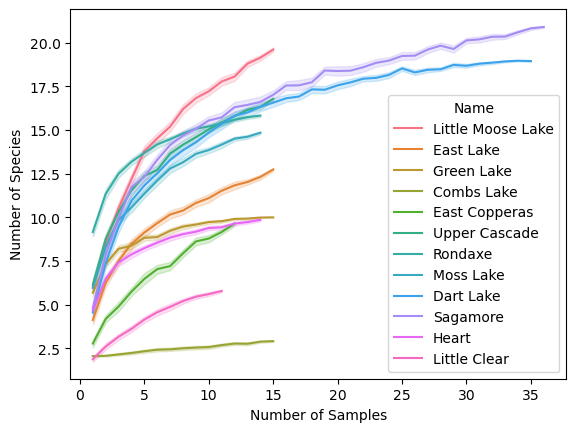

In [625]:
sns.lineplot(data = accumulation_curves[accumulation_curves["Season"] == "Early Fall"], 
             x = "Number of Samples", y = "Number of Species", 
             estimator=np.mean, errorbar=('ci', 95), hue = "Name")

In [289]:
n_repeats = 100
max_samples = len(tmp)

n_samples, n_species = tmp.shape
rarefaction_results = np.zeros(max_samples)
species_counts_matrix = np.zeros((n_repeats, max_samples))
    
    # Precompute the cumulative species counts for all samples
cumulative_counts = np.cumsum(tmp.values, axis=0)

In [290]:
for n in range(1, max_samples + 1):
    for r in range(n_repeats):
        # Randomly sample n individuals across all samples
        sample_indices = np.random.choice(n_samples, n, replace=True)
        sampled_counts = cumulative_counts[sample_indices, :].sum(axis=0)
        species_counts_matrix[r, n-1] = np.count_nonzero(sampled_counts > 0)

    # Calculate the mean
    rarefaction_results[n - 1] = np.mean(species_counts_matrix[:, n-1])

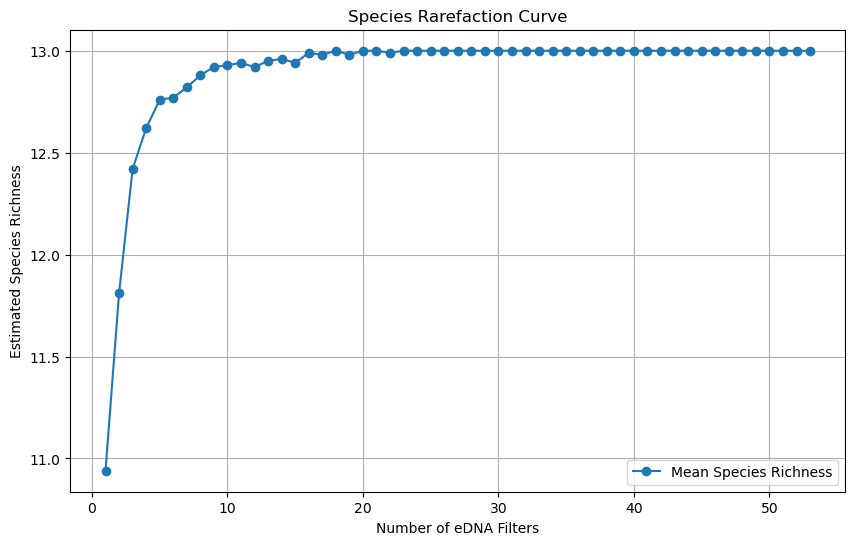

In [291]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(rarefaction_results) + 1), rarefaction_results, marker='o', label='Mean Species Richness')
plt.title('Species Rarefaction Curve')
plt.xlabel('Number of eDNA Filters')
plt.ylabel('Estimated Species Richness')
plt.grid()
plt.legend()
plt.show()

In [292]:
lower_bounds

5.0

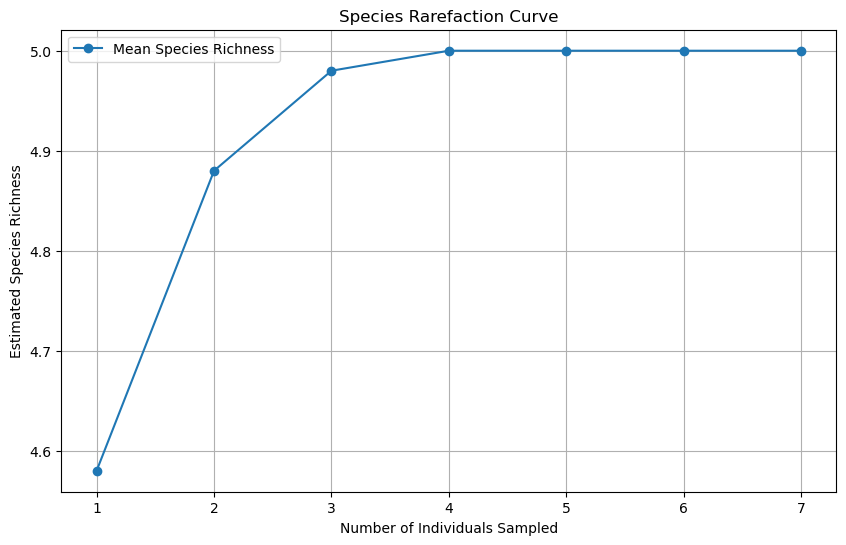

In [198]:
import numpy as np
import pandas as pd

def optimized_rarefaction_curve(data, max_samples=None, n_repeats=100):
    if max_samples is None:
        max_samples = data.sum(axis=1).min()

    n_samples, n_species = data.shape
    rarefaction_results = np.zeros(max_samples)
    
    # Precompute the cumulative species counts for all samples
    cumulative_counts = np.cumsum(data.values, axis=0)

    for n in range(1, max_samples + 1):
        species_counts = np.zeros(n_repeats)
        
        for r in range(n_repeats):
            # Randomly sample n individuals across all samples
            sample_indices = np.random.choice(n_samples, n, replace=True)
            sampled_counts = cumulative_counts[sample_indices, :].sum(axis=0)
            species_counts[r] = np.count_nonzero(sampled_counts > 0)

        # Calculate the mean species richness for this sample size
        rarefaction_results[n - 1] = np.mean(species_counts)

    return rarefaction_results

# Example usage
data = {
    'species_1': [5, 3, 0, 2, 6],
    'species_2': [0, 1, 4, 2, 1],
    'species_3': [2, 1, 0, 0, 0],
    'species_4': [1, 0, 0, 3, 4],
    'species_5': [0, 2, 5, 1, 1]
}

df = pd.DataFrame(data)
rarefaction_results = optimized_rarefaction_curve(df)

# Plotting the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(rarefaction_results) + 1), rarefaction_results, marker='o', label='Mean Species Richness')
plt.title('Species Rarefaction Curve')
plt.xlabel('Number of Individuals Sampled')
plt.ylabel('Estimated Species Richness')
plt.grid()
plt.legend()
plt.show()

In [438]:
lake_metadata[lake_metadata["Mean Bray-Curtis Dissimilarity"] < 0.25]

Pond_num   ID        Name        Lake WATER  Elevation SurficialGeology  \
23     40814  NaN  Combs Lake  COMBS LAKE   COM        554              NaN   

   Lake Type       DOC  Flushing Rate (times/yr)  ...  Pb  Zn  FieldPh  LabPh  \
23  Drainage  high DOC                       NaN  ... NaN NaN   6.0325    NaN   

    AirEqPh  TrueColor  SCONDUCT  LA/SA  Mean Bray-Curtis Dissimilarity  \
23      NaN        NaN       NaN    NaN                        0.080131   

        Season  
23  Early Fall  

[1 rows x 45 columns]

In [295]:
divmetrics = []
for i in bc_dm_data.columns:
    print(i, np.mean(bc_dm_data[i]))
    divmetrics = divmetrics + [np.mean(bc_dm_data[i])]

0 5.419354838709677
1 3.806451612903226
2 4.193548387096774
3 5.0
4 6.064516129032258
5 5.580645161290323
6 4.193548387096774
7 6.67741935483871
8 3.967741935483871
9 5.580645161290323
10 4.0
11 4.870967741935484
12 3.967741935483871
13 4.741935483870968
14 7.806451612903226
15 4.580645161290323
16 4.354838709677419
17 5.774193548387097
18 4.129032258064516
19 4.870967741935484
20 5.0
21 4.387096774193548
22 5.838709677419355
23 4.548387096774194
24 5.709677419354839
25 5.645161290322581
26 4.645161290322581
27 4.161290322580645
28 4.645161290322581
29 5.870967741935484
30 6.096774193548387


In [287]:
np.mean(divmetrics)

1.7090504128625899

In [288]:
np.std(divmetrics)*2

0.5295977277335204

/tmp/ipykernel_870286/2787027068.py:18: UserWarning: The palette list has more values (253) than needed (15), which may not be intended.
  sns.scatterplot(data = finalDf, x = "PC1", y = "PC2", hue = "Name", palette = cc.glasbey_bw[3:], alpha = 1)


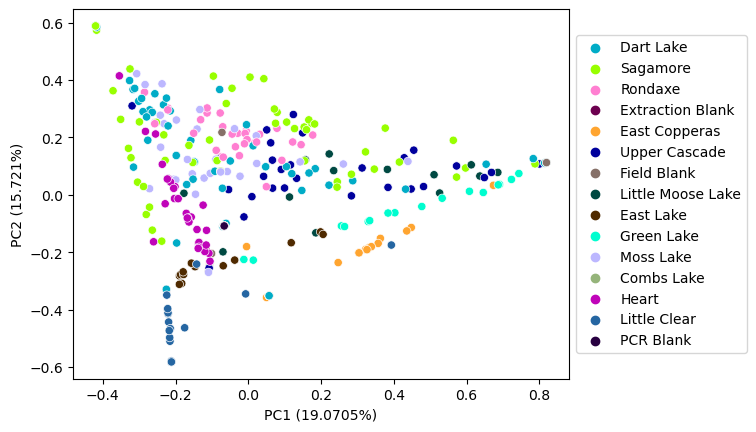

In [110]:
onescaled = asvs.set_index("index").T
ids = onescaled.columns
for samp in ids:
    onescaled[samp] = onescaled[samp] / onescaled[samp].sum() ##Scale to 0 to 1 per samples
    #onescaled.loc[onescaled[samp] > 0, samp] = 1 ##Scale into binary for each sample
onescaled = onescaled.T.reset_index(drop=False)
onescaled = onescaled.fillna(0)
# Separating out the target
y = onescaled.loc[:,['index']].values
x = onescaled.loc[:, onescaled.columns[1:].tolist()].values
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, 
                           columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, asvs[['index']]], axis = 1)
finalDf.columns = ["PC1", "PC2", "EGCF-ID"]
finalDf = finalDf.merge(metadata[["Name", "EGCF-ID", "Season", "Description"]], how = "left", on = "EGCF-ID")
sns.scatterplot(data = finalDf, x = "PC1", y = "PC2", hue = "Name", palette = cc.glasbey_bw[3:], alpha = 1)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("PC1 (" + str(round(pca.explained_variance_ratio_[0] * 100, 4)) + "%)")
plt.ylabel("PC2 (" + str(round(pca.explained_variance_ratio_[1] * 100, 4)) + "%)")
plt.savefig("../pca_onescaled.pdf", dpi = 300, bbox_inches='tight')

/tmp/ipykernel_870286/1102189424.py:17: UserWarning: The palette list has more values (253) than needed (15), which may not be intended.
  sns.scatterplot(data = finalDf, x = "PC1", y = "PC2", hue = "Name", palette = cc.glasbey_bw[3:], alpha = 1)


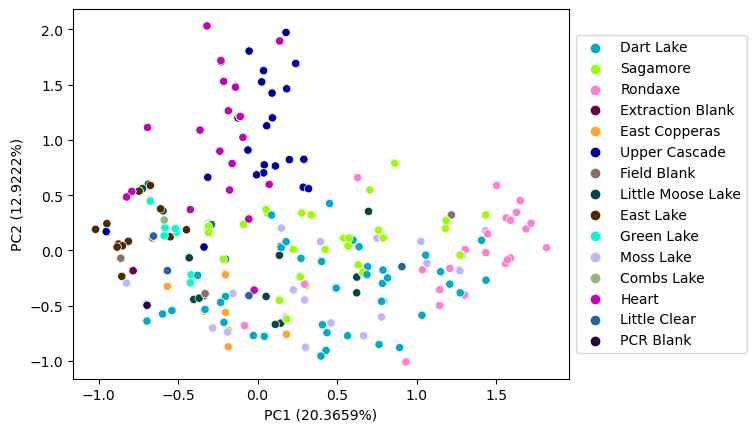

In [111]:
binaryscaled = asvs.set_index("index").T
ids = binaryscaled.columns
for samp in ids:
    binaryscaled.loc[binaryscaled[samp] > 0, samp] = 1 ##Scale into binary for each sample
binaryscaled = binaryscaled.T.reset_index(drop=False)
binaryscaled = binaryscaled.fillna(0)
# Separating out the target
y = binaryscaled.loc[:,['index']].values
x = binaryscaled.loc[:, binaryscaled.columns[1:].tolist()].values
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, 
                           columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, asvs[['index']]], axis = 1)
finalDf.columns = ["PC1", "PC2", "EGCF-ID"]
finalDf = finalDf.merge(metadata[["Name", "EGCF-ID", "Season", "Description"]], how = "left", on = "EGCF-ID")
sns.scatterplot(data = finalDf, x = "PC1", y = "PC2", hue = "Name", palette = cc.glasbey_bw[3:], alpha = 1)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("PC1 (" + str(round(pca.explained_variance_ratio_[0] *100, 4)) + "%)")
plt.ylabel("PC2 (" + str(round(pca.explained_variance_ratio_[1] *100, 4)) + "%)")
plt.savefig("../pca_binary.pdf", dpi = 300, bbox_inches='tight')

In [319]:
tmp["nonzero"] = tmp.astype(bool).sum(axis=1)

In [314]:
tmp = tmp.T
tmp["nonzero"] = tmp.astype(bool).sum(axis=1)

In [321]:
tmp[tmp["nonzero"] < 3]

Species  Lepomis gibbosus,Lepomis auritus,Lepomis macrochirus  \
index                                                           
125                                                      0      
128                                                      0      
229                                                      0      
231                                                      0      
237                                                      0      

Species  Perca flavescens  Lepomis gibbosus  \
index                                         
125                     0                 0   
128                     0                 0   
229                     0                 0   
231                     0                 0   
237                     0                 0   

Species  Micropterus salmoides,Micropterus punctulatus  Salvelinus fontinalis  \
index                                                                           
125                                                  0                      0   
128                                                  0                      0   
229                                                  0                      0   
231                                                  0                      0   
237                                                  0                      0   

Species  Catostomus commersonii  Semotilus atromaculatus  \
index                                                      
125                           0                        0   
128                           0                        0   
229                       86684                    41507   
231                           0                   122349   
237                      150592                        0   

Species  Umbra pygmaea,Umbra limi  Micropterus salmoides  \
index                                                      
125                             0                      0   
128                             0                      0   
229                             0                      0   
231                             0                      0   
237                             0                      0   

Species  Notophthalmus viridescens  ...  Cottus confusus,Cottus cognatus  \
index                               ...                                    
125                              0  ...                                0   
128                              0  ...                                0   
229                              0  ...                                0   
231                              0  ...                                0   
237                              0  ...                                0   

Species  Coregonus clupeaformis  \
index                             
125                           0   
128                           0   
229                           0   
231                           0   
237                           0   

Species  Anas platyrhynchos,Anas poecilorhyncha,Anas zonorhyncha,Tadorna tadorna  \
index                                                                              
125                                                      0                         
128                                                      0                         
229                                                      0                         
231                                                      0                         
237                                                      0                         

Species  Hypophthalmichthys molitrix,Hypophthalmichthys nobilis  \
index                                                             
125                                                      0        
128                                                      0        
229                                                      0        
231                                                      0        
237                               

In [311]:
tmp["Chrosomus eos"]

index
121       0
122       0
123       0
124       0
125       0
126       0
127       0
128       0
129       0
130       0
131       0
132       0
133       0
134       0
135       0
136       0
224       0
225       0
226       0
227       0
228       0
229       0
230       0
231       0
232       0
233       0
234       0
235       0
236       0
237       0
238       0
239    1466
Name: Chrosomus eos, dtype: int64

In [285]:
tmp[tmp["nonzero"] == 1]

Genus  Lepomis  Perca  Micropterus  Salvelinus  Catostomus  Semotilus  Umbra  \
index                                                                          
125          0      0            0           0           0          0      0   
237          0      0            0           0      150592          0      0   

Genus  Notophthalmus  Notemigonus  Ameiurus  ...  Sus  Oncorhynchus  Capra  \
index                                        ...                             
125                0            0         0  ...    0             0      0   
237                0            0         0  ...    0             0      0   

Genus  Siniperca  Hemidactylium  Lophodytes  Anas,Tadorna  Aphelocoma  \
index                                                                   
125            0              0           0             0           0   
237            0              0           0             0           0   

Genus  Catostomus,Xyrauchen  nonzero  
index                                 
125                       0        1  
237                       0        1  

[2 rows x 44 columns]

In [272]:
tmp.set_index("index").T

index                    231
Genus                       
Lepomis                    0
Perca                      0
Micropterus                0
Salvelinus                 0
Catostomus                 0
Semotilus             122349
Umbra                      0
Notophthalmus              0
Notemigonus                0
Ameiurus                   0
Chrosomus              39927
Ambloplites                0
Rhinichthys                0
Prosopium                  0
Pimephales                 0
Fundulus                   0
Couesius                   0
Osmerus                    0
Cottus                     0
Coregonus                  0
Luxilus                    0
Hypophthalmichthys         0
Thaleichthys               0
Salmo                      0
Noturus                    0
Mylopharyngodon            0
Bos                        0
Carassius                  0
Eurycea                    0
Exoglossum,Erimystax       0
Coregonus,Stenodus         0
Homo                       0
Sander                     0
Lateolabrax                0
Sus                        0
Oncorhynchus               0
Capra                      0
Siniperca                  0
Hemidactylium              0
Lophodytes                 0
Anas,Tadorna               0
Aphelocoma                 0
Catostomus,Xyrauchen       0

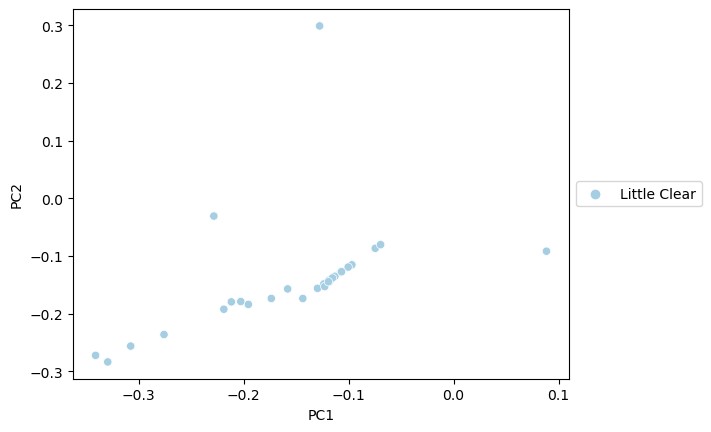

In [253]:
sns.scatterplot(data = finalDf[finalDf["Name"] == "Little Clear"], x = "PC1", y = "PC2", hue = "Name", palette = "Paired")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [184]:
finalDf[finalDf["Name"] == "Little Clear"][finalDf["PC1"] > 0]

/tmp/ipykernel_1032660/3530529862.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  finalDf[finalDf["Name"] == "Little Clear"][finalDf["PC1"] > 0]


PC1       PC2 EGCF-ID          Name
303  0.093751 -0.082007      45  Little Clear

In [183]:
finalDf[finalDf["Name"] == "Little Clear"][finalDf["PC2"] > -0.1][finalDf["PC1"] < -0.2]

/tmp/ipykernel_1032660/102720039.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  finalDf[finalDf["Name"] == "Little Clear"][finalDf["PC2"] > -0.1][finalDf["PC1"] < -0.2]


PC1       PC2 EGCF-ID          Name
295 -0.232031 -0.046967     387  Little Clear

In [170]:
heart = asv[finalDf["index"][finalDf["principal component 2"] > 2].tolist() + ["Species"]]

In [151]:
heart["nonzero"] = heart[finalDf["index"][finalDf["principal component 2"] > 2].tolist()].astype(bool).sum(axis=1)

/tmp/ipykernel_1032660/2415583016.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heart["nonzero"] = heart[finalDf["index"][finalDf["principal component 2"] > 2].tolist()].astype(bool).sum(axis=1)


In [152]:
heart[heart["nonzero"] > 0]

316  319   330   332   334   337  346  352  67  \
0       0    0  4343  7725  6310     0    0    0   0   
1       0    0  2586  4961  3933     0    0    0   0   
2       0    0     0  5460     0  9062    0    0   0   
3       0    0  2454  4280  3528     0    0    0   0   
5       0    0     0  4200     0  6152    0    0   0   
...   ...  ...   ...   ...   ...   ...  ...  ...  ..   
6514    0    0     0     0     0     0    0   71   0   
6550    0    0    65     0     0     0    0    0   0   
6582    0    0     0     0     0     0   61    0   0   
6811    0    0     0    18     0     0    0    0   0   
6868    0    0    11     0     0     0    0    0   0   

                                                Species  nonzero  
0     Lepomis gibbosus,Lepomis auritus,Lepomis macro...        3  
1     Lepomis gibbosus,Lepomis auritus,Lepomis macro...        3  
2                                      Perca flavescens        2  
3                                      Lepomis gibbosus        3  
5                                      Perca flavescens        2  
...                                                 ...      ...  
6514                               Salvelinus namaycush        1  
6550  Coregonus lavaretus,Coregonus oxyrinchus,Coreg...        1  
6582                              Catostomus catostomus        1  
6811                                Lepomis macrochirus        1  
6868  Lepomis gibbosus,Lepomis auritus,Lepomis macro...        1  

[906 rows x 11 columns]

In [153]:
finalDf["index"][finalDf["principal component 2"] > 2].tolist()

['316', '319', '330', '332', '334', '337', '346', '352', '67']

In [154]:
metadata[metadata["EGCF-ID"].isin(finalDf["index"][finalDf["principal component 2"] > 2].tolist())]

Name       Date        Season  ALSC   Time Site Description  \
64   Little Clear  6/22/2023  Early Summer     0  10:50    5     Surface   
313      Sagamore  9/29/2023    Early Fall     0  10:20    3        Deep   
316      Sagamore  9/29/2023    Early Fall     0  10:10    3     Surface   
327      Sagamore  9/29/2023    Early Fall     0  11:15    4     Surface   
329      Sagamore  9/29/2023    Early Fall     0  12:30    6     Surface   
331      Sagamore  9/29/2023    Early Fall     0  13:00   7A  Near Shore   
334      Sagamore  9/29/2023    Early Fall     0  13:45    2        Deep   
343      Sagamore  10/3/2023    Early Fall     0  11:35    9        Deep   
349      Sagamore  10/3/2023    Early Fall     0  10:50    1        Deep   

    EGCF-ID Replicate  Latitude  Longitude  Water Depth eDNA  \
64       67         1  44.66043  -74.49654         13.5    x   
313     316         2  43.76811   -74.6297         22.0    x   
316     319         2  43.76811   -74.6297         22.0    x   
327     330         1  43.76923  -74.61441         16.9    x   
329     332         1  43.76720   -74.6155         15.5    x   
331     334         1  43.76598  -74.61809          1.5    x   
334     337         1  43.76605   -74.6233          4.3    x   
343     346         1  43.77026   -74.6245         13.1    x   
349     352         1  43.76848   -74.6255         13.1    x   

     Vol. Filtered (ml)  eDNA Depth (m)  Temp at Depth  DO at Depth  \
64                 75.0             0.0           22.8          9.3   
313               150.0            12.0            6.8          5.0   
316               150.0             0.0           16.0          8.6   
327               150.0             0.0           16.0          8.6   
329               150.0             0.0           16.0          8.6   
331               150.0             0.0           16.0          8.6   
334               117.0             3.0           15.5          8.2   
343               150.0            11.0            7.0          5.1   
349               150.0            11.0            7.0          5.1   

     Secchi Depth (M) Notes  
64                2.5   NaN  
313               1.7   NaN  
316               1.7   NaN  
327               1.7   NaN  
329               1.7   NaN  
331               1.7   NaN  
334               1.7   NaN  
343               1.7   NaN  
349               1.7   NaN

In [34]:
a

principal component 1  principal component 2 index
0                -5.970381              -0.388167     1
1                -1.664791              -6.996962    10
2               -11.126194               5.709583   100
3               -12.170537              -0.825560   101
4                -3.844410               2.851169   102
..                     ...                    ...   ...
382              -8.531522              -2.044810    95
383             -26.800583              -5.792653    96
384             -15.321282               2.386044    97
385              -8.550235               0.144649    98
386              -7.691164              -3.346737    99

[387 rows x 3 columns]

In [3]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"

In [4]:
df = pd.read_csv(url, names=['sepal length','sepal width','petal length','petal width','target'])

In [24]:
df

sepal length  sepal width  petal length  petal width          target
0             5.1          3.5           1.4          0.2     Iris-setosa
1             4.9          3.0           1.4          0.2     Iris-setosa
2             4.7          3.2           1.3          0.2     Iris-setosa
3             4.6          3.1           1.5          0.2     Iris-setosa
4             5.0          3.6           1.4          0.2     Iris-setosa
..            ...          ...           ...          ...             ...
145           6.7          3.0           5.2          2.3  Iris-virginica
146           6.3          2.5           5.0          1.9  Iris-virginica
147           6.5          3.0           5.2          2.0  Iris-virginica
148           6.2          3.4           5.4          2.3  Iris-virginica
149           5.9          3.0           5.1          1.8  Iris-virginica

[150 rows x 5 columns]

In [155]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

features = ['sepal length', 'sepal width', 'petal length', 'petal width']

# Separating out the features
x = df.loc[:, features].values

# Separating out the target
y = df.loc[:,['target']].values

# Standardizing the features
x = StandardScaler().fit_transform(x)

In [6]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

principalComponents = pca.fit_transform(x)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [7]:
finalDf = pd.concat([principalDf, df[['target']]], axis = 1)

In [10]:
finalDf

principal component 1  principal component 2          target
0                -2.264542               0.505704     Iris-setosa
1                -2.086426              -0.655405     Iris-setosa
2                -2.367950              -0.318477     Iris-setosa
3                -2.304197              -0.575368     Iris-setosa
4                -2.388777               0.674767     Iris-setosa
..                     ...                    ...             ...
145               1.870522               0.382822  Iris-virginica
146               1.558492              -0.905314  Iris-virginica
147               1.520845               0.266795  Iris-virginica
148               1.376391               1.016362  Iris-virginica
149               0.959299              -0.022284  Iris-virginica

[150 rows x 3 columns]

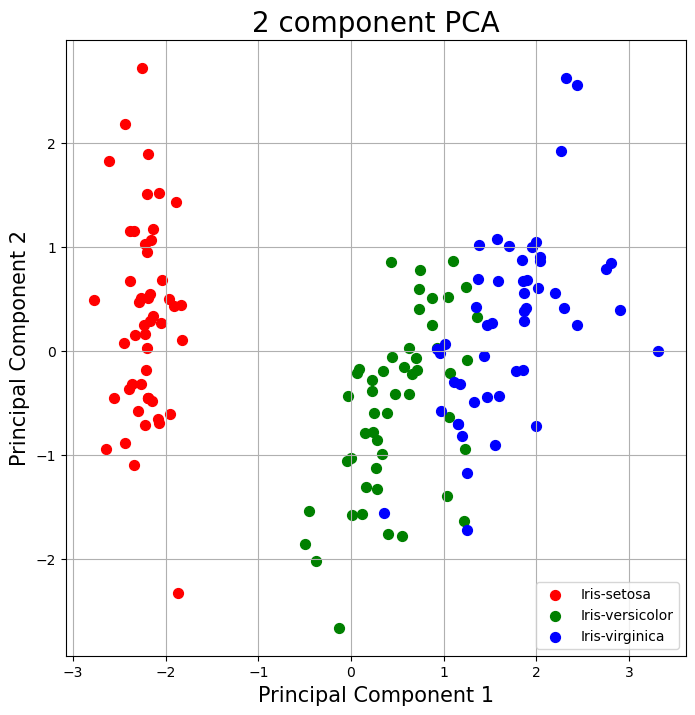

In [8]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [171]:
pca.explained_variance_ratio_

array([0.13119405, 0.11220748])